In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (12,6)

## Step 0
### Data Acquisition

In this preliminary section, we gather market data from *yahoo finance* of six sector ETFs serving as foundation to our trading strategies.
We also download daily prices of the ETF replicating the S\&P500 index, SPY to be used as the basis for a market volatility tracker.

In [2]:
tickers_market = ['SPY']
tickers_energy = ['XLE', 'XOP']
tickers_gold = ['GDX', 'GLD']
tickers_tech = ['IYW', 'XLK']

start = '2017-01-01'
end = '2022-01-01'

data_market = yf.download(tickers_market, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_energy = yf.download(tickers_energy, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_gold = yf.download(tickers_gold, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 
data_tech = yf.download(tickers_tech, start=start, end=end, progress=False, auto_adjust=True)["Close"] # pyright: ignore[reportOptionalSubscript] 

prices = pd.concat([data_market, data_energy, data_gold, data_tech], axis=1)
rets = pd.DataFrame(np.log(prices / prices.shift(1))).dropna()
rets

Ticker,SPY,XLE,XOP,GDX,GLD,IYW,XLK
Date,,,,,,,
2017-01-04,0.005932,-0.002103,0.004749,0.007326,0.003524,0.004448,0.003478
2017-01-05,-0.000795,-0.002503,-0.003085,0.056753,0.015396,0.001560,0.001633
2017-01-06,0.003572,0.000923,-0.007394,-0.035538,-0.007400,0.009473,0.007314
2017-01-09,-0.003307,-0.014601,-0.028410,0.003122,0.008199,0.002840,-0.000202
2017-01-10,0.000000,-0.009134,0.000000,0.007099,0.004251,0.000324,0.000202
...,...,...,...,...,...,...,...
2021-12-27,0.014053,0.021622,0.039652,0.000958,0.002364,0.020187,0.021225
2021-12-28,-0.000818,-0.000713,-0.008699,-0.007690,-0.004319,-0.008061,-0.005221
2021-12-29,0.001279,-0.006442,-0.004072,0.004173,-0.000297,-0.000431,0.000853


## Step 1
### Foundational Analysis, part A: BDS test on residuals of pairs trading returns

Our pair-trading strategy is based on a linear relationship between the pair.
The spread might have nonlinear relationships that we miss when we decide to model it linearly. Hence, we should verify we are not missing important nonlinear patterns in the spread. In order to do so, we are going to resort to the BDS test.

The trick is that if there are nonlinear relationships, the residuals of our linear model will not be random.
In fact, they will have a discernible nonlinear pattern. So to check for nonlinearity, what we really will check for, is whether the residuals of our linear fit are random (in which case there is no extra pattern or nonlinearity) or not.

If the data is random (and independent and identically distributed), then the probability of two $m$-dimensional points being close equals the probability of their one-dimensional components being close, raised to the $m^{th}$ power:

$$C_m(\epsilon) = [C_1(\epsilon)]^m$$

Violations of this indicate nonlinear relationships. The BDS statistic is given by:

$$BDS_{m,\epsilon} = \sqrt{T_m} \frac{C_m(\epsilon) - [C_1(\epsilon)]^m}{\sigma_{m,\epsilon}}$$

where

**Embedding dimension ($m$)**:We embed our 1-dimensional residuals into a higher dimensional system. It is standard procedure to test in multiple dimensions, since different dependencies appear at different scales. 

**Distance parameter ($\epsilon$)**: Typically taken as multiples of the standard deviation.

**Number m-dimensional vectors ($T_m$)**: The 1-dimensional data is embedded into $m$ dimensions, and then split into $T_m$ m-dimensional arrays.

**Asymptotic standard deviation of the numerator ($\sigma_{m,\epsilon}$)**: Normalization factor.

Under the null of independence, this follows a standard normal distribution. In simple words, we assume there is a nonlinear relationships if $|z|>1.96$ with a $95\%$ confidence. Similarly, a p-value $p<0.05$ will tell us the data is not random.

In [3]:
from statsmodels.tsa.stattools import bds
from arch import arch_model
import matplotlib.colors as mcolors

In [4]:
## Code to run the BDS on the residuals
def bds_residuals(ticker1,ticker2):
    # OLS regression and spread
    y = rets[ticker1]
    X = sm.add_constant(rets[ticker2])
    model_energy = sm.OLS(y, X).fit()
    alpha_energy, beta_energy = model_energy.params
    spread_energy = y - (alpha_energy + beta_energy * rets[ticker2])
    spread_energy.name = "Spread"
    print(f"{ticker1} on {ticker2} Regression beta coefficient: ", beta_energy)
    m_vals  = list(range(2,10))
    eps_mul = [0.25* i for i in range(1,8)]
    rows = []
    for m in m_vals:
        for k in eps_mul:
            stats, pvals = bds(y.to_numpy(), max_dim=m, epsilon=k *spread_energy.std())
            z = float(np.atleast_1d(stats)[-1])
            p = float(np.atleast_1d(pvals)[-1])
            rows.append({"m": m, "ε": f"{k:.1f}σ", "z": z, "p": p})
    bds_filt = pd.DataFrame(rows)
    print(f"We obtain an average p value of {bds_filt['p'].mean()}")
    return bds_filt
## PLOTTING FUNCTIONS
def make_pivot(df: pd.DataFrame, value: str) -> pd.DataFrame:
    """Return a m x epsilon table ready for imshow."""
    tbl = df.copy()
    # strip the trailing 'σ' and cast to float so eps is numeric & sortable
    tbl["eps_float"] = tbl["ε"].str.rstrip("σ").astype(float)
    tbl = tbl.pivot(index="m", columns="eps_float", values=value)
    # ensure natural order (increasing m downward, ε across)
    tbl.sort_index(axis=0, inplace=True)
    tbl.sort_index(axis=1, inplace=True)
    return tbl

def plot_bds_heatmaps(bds_data: pd.DataFrame):
    """Generates side-by-side heatmaps for BDS z-scores."""
    filt_piv = make_pivot(bds_data, "z")
    
    # Create a figure with two subplots side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=110) #figsize=(14, 6), dpi=110)

    # Plot 1: Standard heatmap with default color scale
    im1 = ax1.imshow(filt_piv, cmap='viridis') # aspect="auto",
    ax1.set_title("BDS z-scores: GARCH(1,1) residuals")
    ax1.set_xticks(np.arange(len(filt_piv.columns)))
    ax1.set_xticklabels(filt_piv.columns)
    ax1.set_yticks(np.arange(len(filt_piv.index)))
    ax1.set_yticklabels(filt_piv.index)
    ax1.set_xlabel("ε (in σ units)")
    ax1.set_ylabel("Embedding dimension m")
    fig.colorbar(im1, ax=ax1, label="z-score", shrink=0.7, aspect=20*0.8)

    # Plot 2: Heatmap with custom color scale for significance
    bounds = [-1000, -1.96, 1.96, 1000]
    cmap = mcolors.ListedColormap(['red', 'green', 'pink'])
    norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=cmap.N)
    
    im2 = ax2.imshow(filt_piv, cmap=cmap, norm=norm) # aspect="auto",
    ax2.set_title("BDS z-scores: Highlighted Rejection Region")
    ax2.set_xticks(np.arange(len(filt_piv.columns)))
    ax2.set_xticklabels(filt_piv.columns)
    ax2.set_yticks(np.arange(len(filt_piv.index)))
    ax2.set_yticklabels(filt_piv.index)
    ax2.set_xlabel("ε (in σ units)")
    ax2.set_ylabel("Embedding dimension m")
    
    cbar = fig.colorbar(im2, ax=ax2, label="z-score", shrink=0.7, aspect=20*0.8)
    cbar.set_ticks([-1.96, 0, 1.96])
    cbar.set_ticklabels(['< -1.96', '0', '> 1.96'])

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3)
    plt.show()

####  Energy ETFs

XLE on XOP Regression beta coefficient:  0.6396329917739756
We obtain an average p value of 9.535165915473455e-05


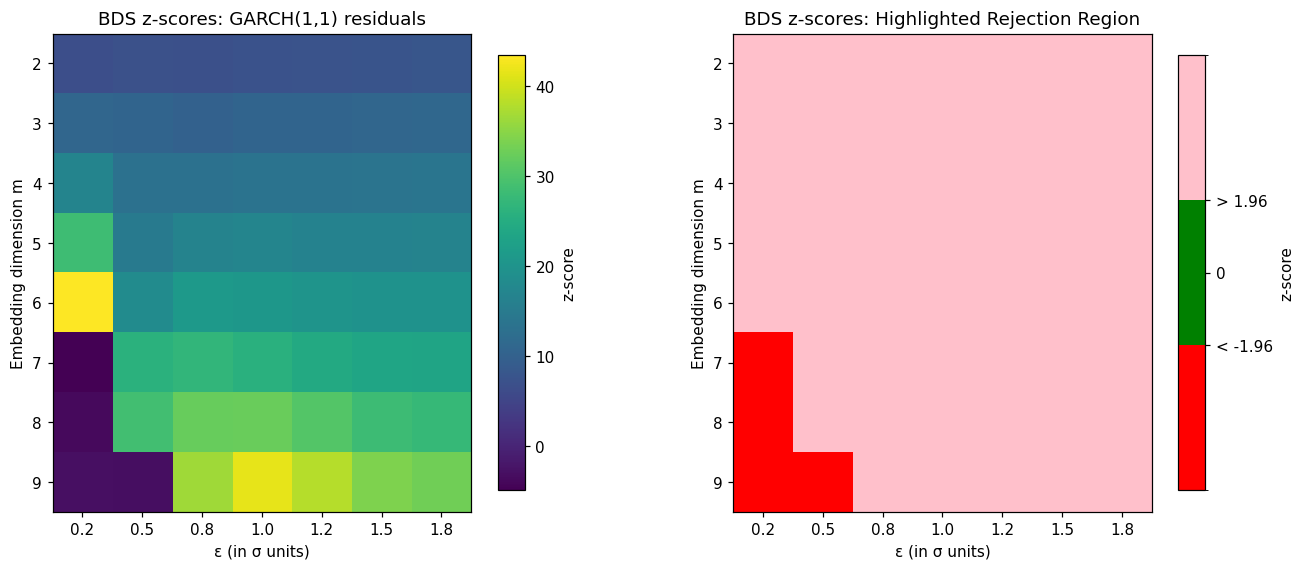

In [5]:
bds_energy = bds_residuals("XLE","XOP")
plot_bds_heatmaps(bds_energy)

The plot on the left is a heat map for the $Z-scores$ of the $BDS$ test, while the one on the right forgets about the particular value and just signals the  areas there the residuals are random (in green), or where there is a nonlinear dependence (pink and red).

As we can see in this particular instance, nonlinear relations along the scales tested are present. The high values of the $Z-score$ anticipate that volatility clustering might be the main suspect, before empirical verification on whether this may be, using the *statsmodels* library. Let us see if the same happens in the other datasets.

####  Gold ETFs

GDX on GLD Regression beta coefficient:  1.954156311743339
We obtain an average p value of 0.004719072160384506


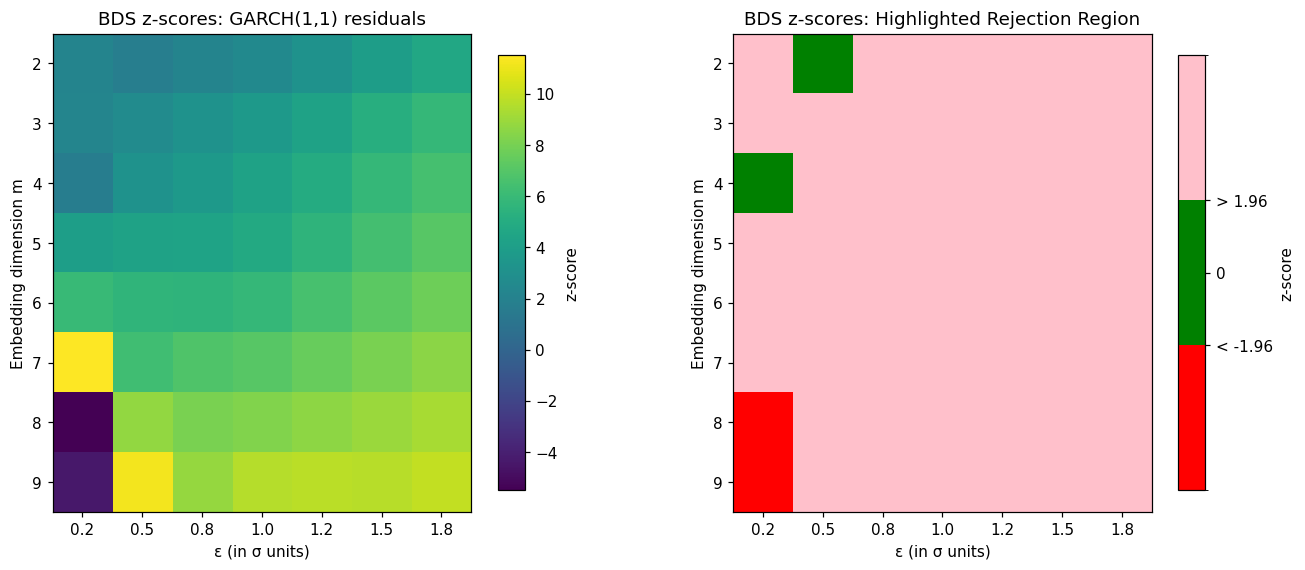

In [6]:
bds_gold = bds_residuals("GDX","GLD")
plot_bds_heatmaps(bds_gold)

In this case, we see two small regions where the data seems to be linear. Unfortunately this seems related to small scales, which are short lived. Thus, our data is essentially nonlinear in all regimes of practical interest, except for those relevant for high frequency trading, which is not part of our strategy.

#### Tecnhnology ETFs

IYW on XLK Regression beta coefficient:  0.9986181629085071
We obtain an average p value of 0.0003744685253004738


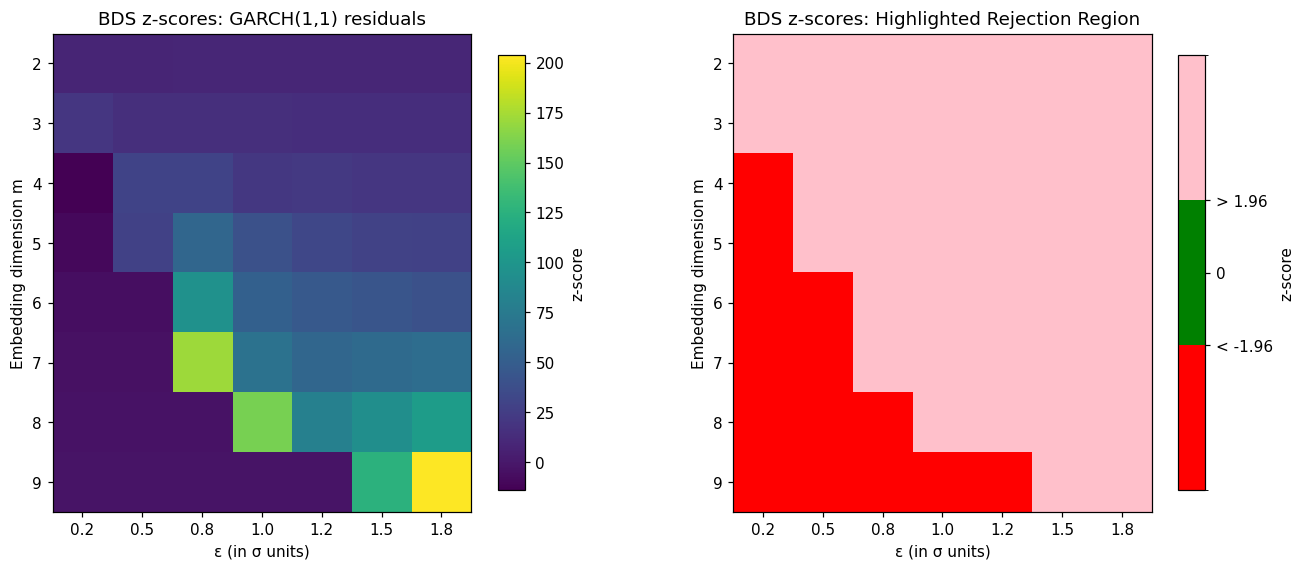

In [7]:
bds_tech = bds_residuals("IYW","XLK")
plot_bds_heatmaps(bds_tech)

Again, there is no regime where a linear relationship fully captures the pair. This is disappointing, considering that we want to exploit linearities for a pair trading strategy. 

On the other hand, the nonlinear relation we are missing might be volatility clustering, which mainly happens in stressed markets. If that is the case, we can still use the spread to do a pair trading strategy, since we can monitor the state of the market via the VIX, or some other indicator or signal. 

The fact that we do not capture volatility clustering might not be an issue. As long as we are aware that our model does not capture most of the variability of the spread within the trading pair in that particular situation, the issue can be addressed by halting the trading strategy in that regime.

#### Removing Volatility clustering

We will apply prefiltering in our residuals using a GARCH(1,1) models to isolate 
truly non-linear dependencies from mere volatility clustering. If our pair spread
residuals are random after this procedure, we can apply our linear pair trading 
strategy knowing there is no extra nonlinear pattern we are missing.


In [8]:
def bds_residuals_garch(ticker1,ticker2):
    # OLS regression and spread
    y = rets[ticker1]
    X = sm.add_constant(rets[ticker2])
    model_energy = sm.OLS(y, X).fit()
    alpha_energy, beta_energy = model_energy.params
    spread_energy = y - (alpha_energy + beta_energy * rets[ticker2])
    spread_energy.name = "Spread"
    print(f"{ticker1} on {ticker2} Regression beta coefficient: ", beta_energy)
    garch = arch_model(100*spread_energy, p=1, q=1, mean="Zero")
    fit = garch.fit(disp="off")
    std_resid = fit.std_resid /100
    m_vals  = list(range(2,10))
    eps_mul = [0.25* i for i in range(1,8)]
    rows = []
    for m in m_vals:
        for k in eps_mul:
            stats, pvals = bds(std_resid.to_numpy(), max_dim=m, epsilon=k *spread_energy.std())
            z = float(np.atleast_1d(stats)[-1])
            p = float(np.atleast_1d(pvals)[-1])
            rows.append({"m": m, "ε": f"{k:.1f}σ", "z": z, "p": p})
    bds_filt = pd.DataFrame(rows)
    print(f"We obtain a p value of {bds_filt['p'].mean()}")
    return bds_filt
def plot_reduction(piv,piv2):
    raw_flat  = make_pivot(piv,"z").stack()
    filt_flat = make_pivot(piv2,"z").stack()
    reduction = (np.abs(raw_flat) - np.abs(filt_flat)).rename("Δ|z| (raw - filt)")
    plt.figure(dpi=110) #figsize=(12,6),dpi=110)
    reduction.plot(kind="bar")
    plt.title("Drop in absolute z‑score after GARCH filtering")
    plt.xlabel("(m, ε) pair")
    plt.ylabel("Reduction in |z|")
    plt.tight_layout()
    plt.show()

##### Energy ETFs

XLE on XOP Regression beta coefficient:  0.6396329917739756
We obtain a p value of 0.6377148284109586


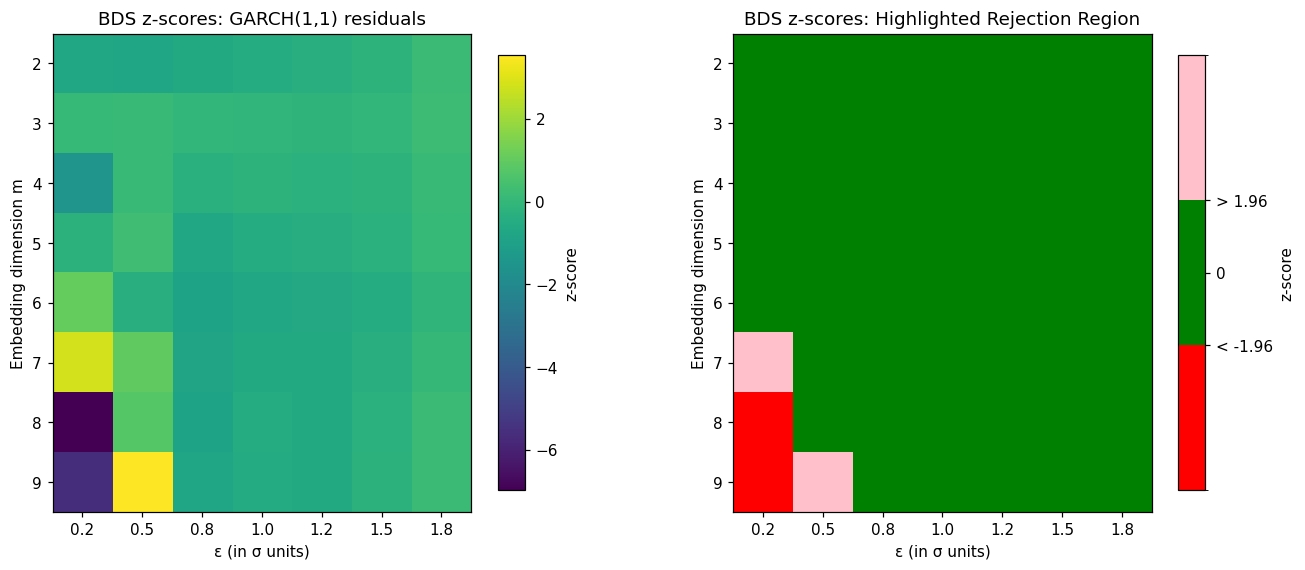

In [9]:
bds_energy_garch = bds_residuals_garch("XLE","XOP")
plot_bds_heatmaps(bds_energy_garch)

Our residuals are mostly random, except for the lower left corner, which corresponds to fast signal changes (small $\epsilon$) that persist over time (large $m$). As we trade over long horizon, the fast changes do not matter as much, and thus this issue is outside our scales of interest. 

Therefore our linear model for pair trading can be used with confidence for this pair. As long as we are aware that volatility clustering might dominate it and should be monitored to complement the model, we can visualize how much our $z$-scores dropped by using GARCH to exclude volatility clustering.

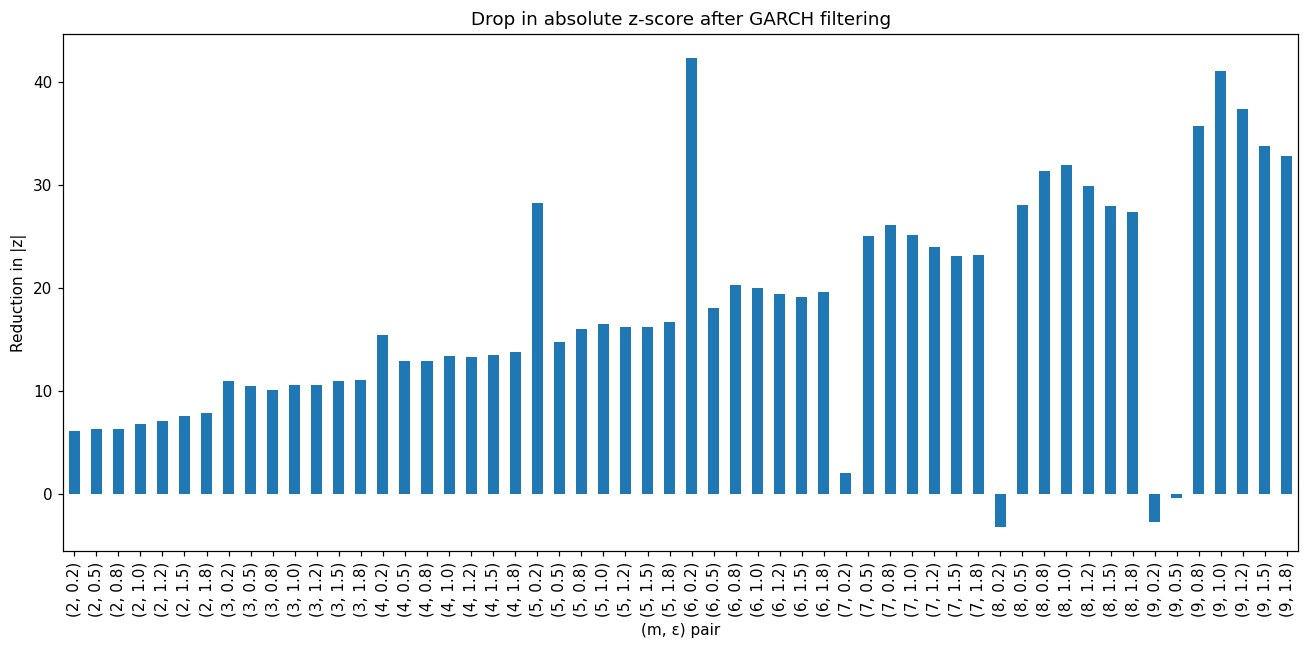

In [10]:
plot_reduction(bds_energy,bds_energy_garch)

The fact that the $z$-scores were as high as $40$ and dropped all the way to $|z|<1.96$, indicates that volatility clustering was the nonlinear relation we were missing.

##### Gold ETFs

GDX on GLD Regression beta coefficient:  1.954156311743339
We obtain a p value of 0.6102458032498573


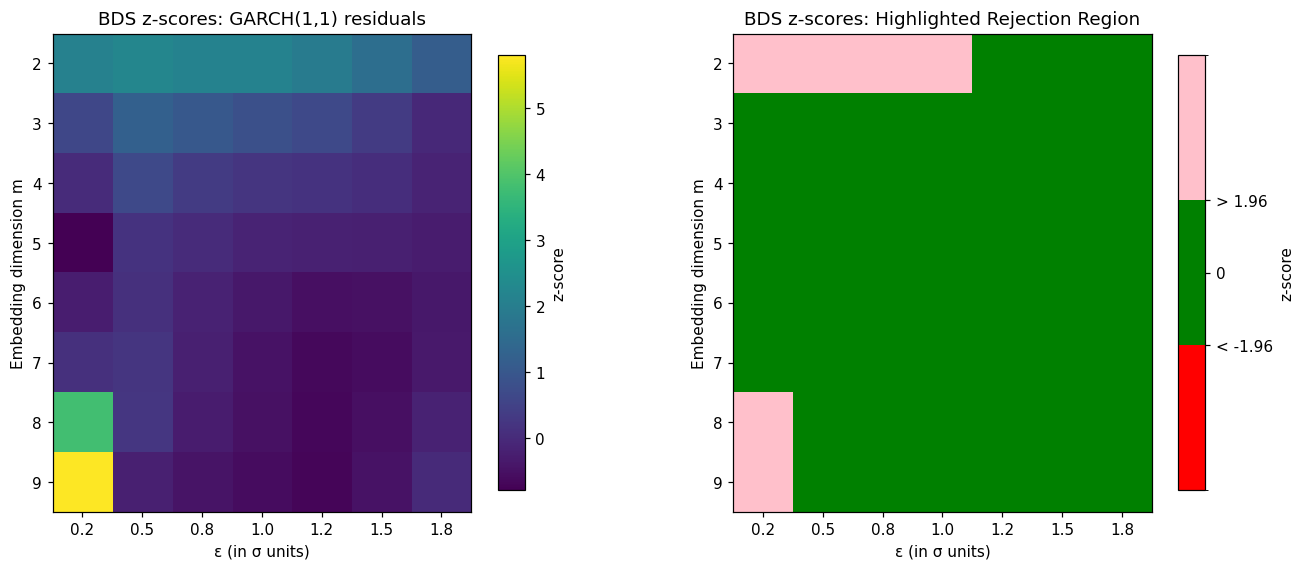

In [11]:
bds_gold_garch = bds_residuals_garch("GDX","GLD")
plot_bds_heatmaps(bds_gold_garch)

The residuals are mostly random, but show nonlinear dependence in the same scales as before, and also in others. So while the linear model captures most
of the patterns in the data, there exist short term price actions it does not capture, and that exhibit nonlinear dependence. 

This tells us one should trade this pair over medium to long term scales. This is exactly what we intended to do, as this is a mean return strategy. Again, we can visualize the change in $z$-scores.

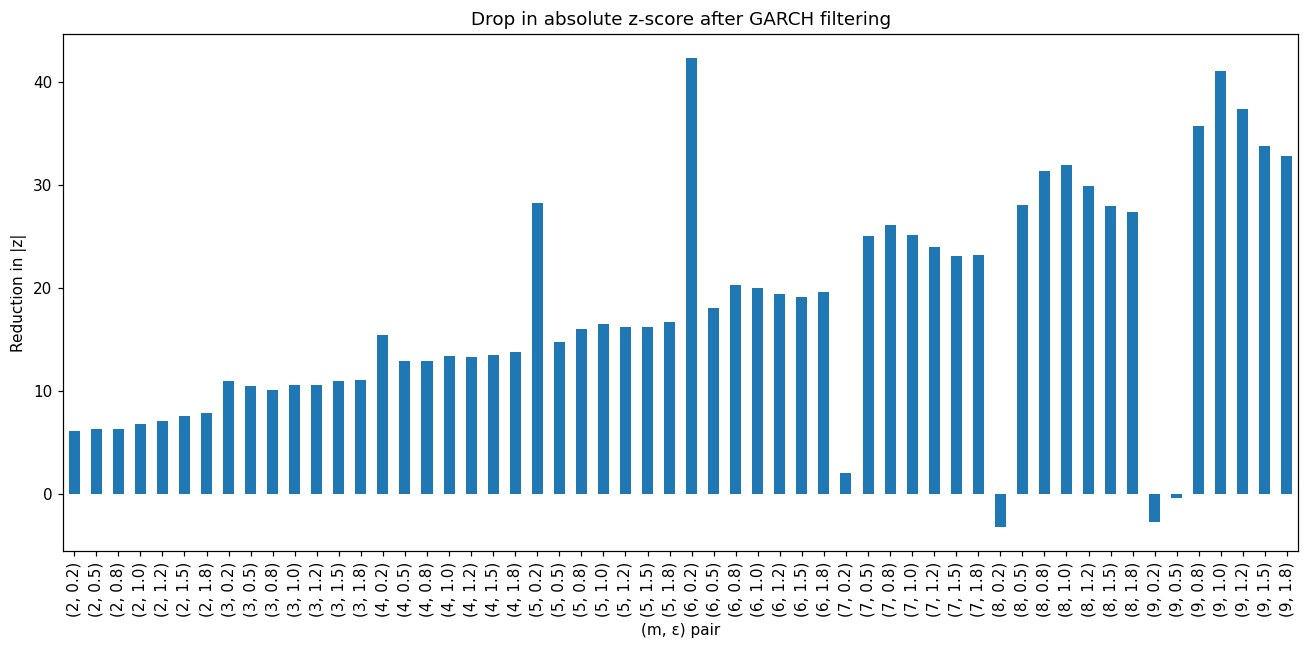

In [12]:
plot_reduction(bds_energy,bds_energy_garch)

##### Technology ETFs

IYW on XLK Regression beta coefficient:  0.9986181629085071
We obtain a p value of 0.10253505854613967


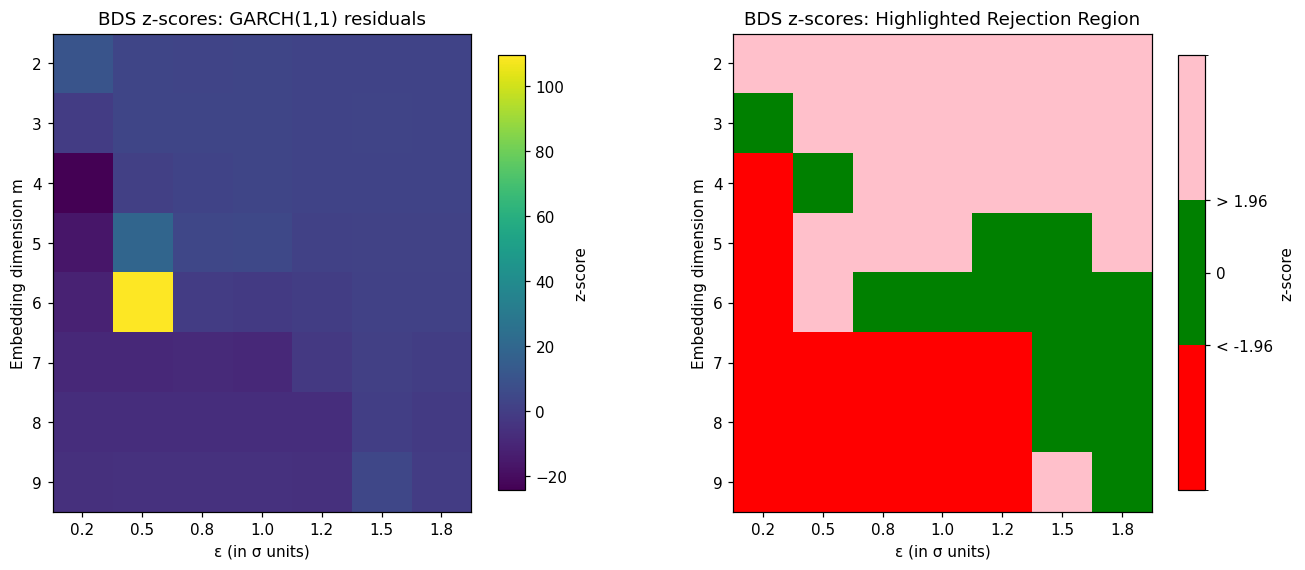

In [13]:
bds_tech_garch = bds_residuals_garch("IYW","XLK")
plot_bds_heatmaps(bds_tech_garch)

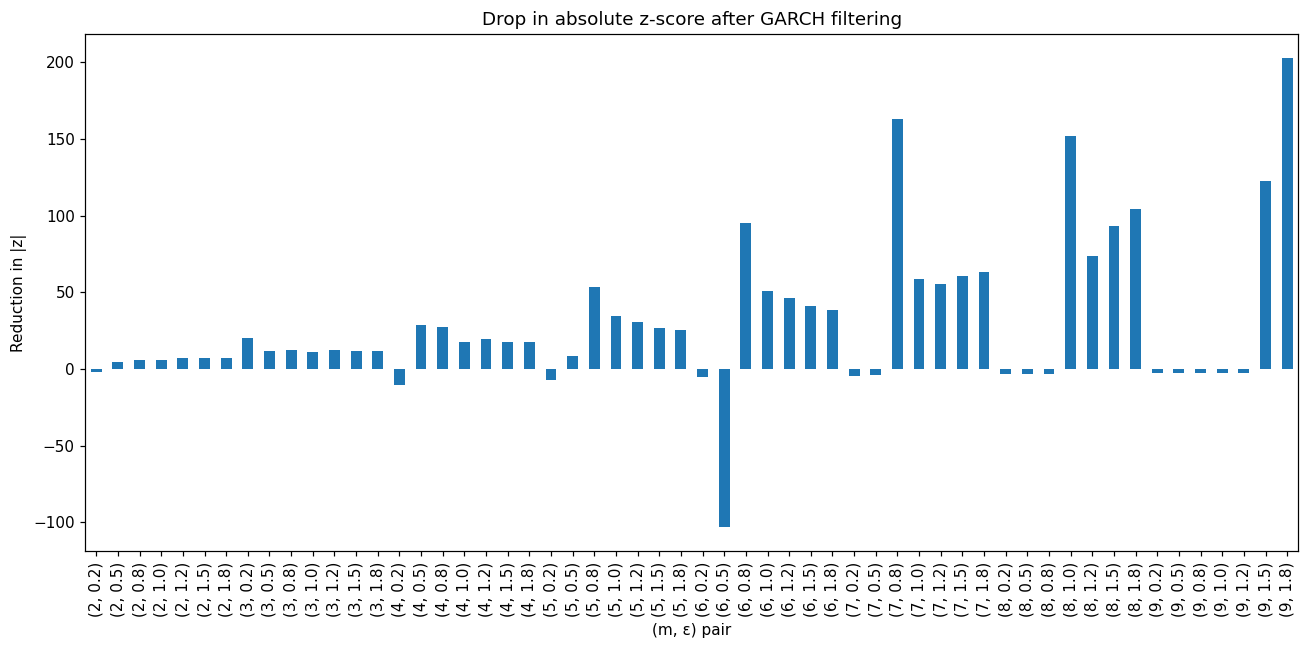

In [14]:
plot_reduction(bds_tech,bds_tech_garch)

Even though using a $\text{GARCH}(1,1)$ greatly reduced the magnitude of the $z$-scores, as evidenced in the bar plot, this was not enough for this dataset as the heatmap tells us. Most of the scales exhibit nonlinear relationships in the spread beyond volatility clustering, so we are missing patterns in our predictions when using a linear model in this dataset. In fact, we do so most of the time. 

The $p\approx0.0976$ tells us the data is definitely not random, which means our model is not completely adequate for pair trading, due to missing, nonlinear relations. However, based on the $z$-values and their reduction, the missing nonlinearities are not the main driving force of returns, so we might still use the model, albeit with low confidence.

### Foundational Analysis, part B: Engle-Granger cointegration test  

In [15]:
from statsmodels.tsa.stattools import adfuller

In this section, we will determine returns from three trading strategies, each between a pair of ETFs belonging to a specific economic sector, realised within the period January 2017 - December 2021.

The flexibility of the Python script used to code the strategy allows to easily cover all three sectors, instead of only picking one beforehand.

The three pairs of ETFs involved are:

- Energy sector: XLE vs XOP
- Gold sector: GDX vs GLD
- Technology sector: IYW vs XLK 

#### Strategy 1: Energy ETFs

A preliminary look at the price movements during the designated period:

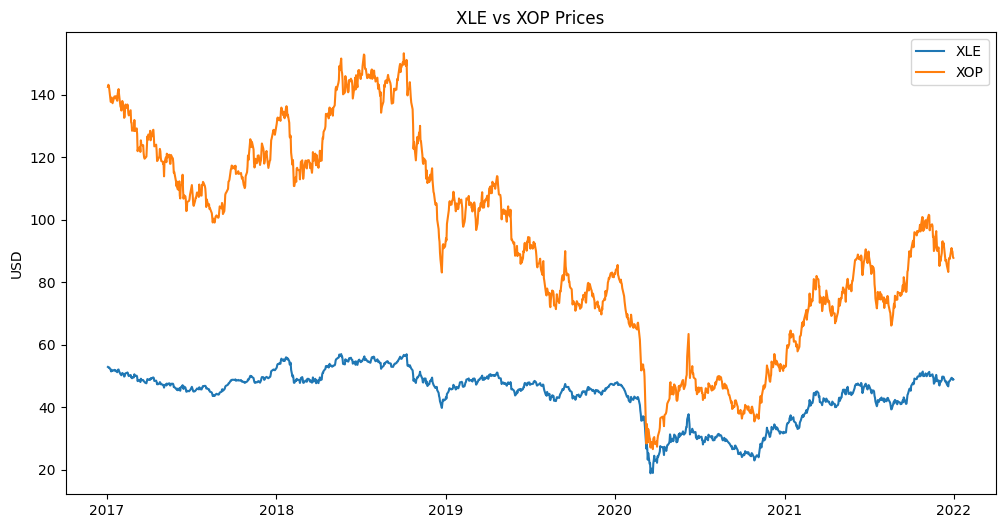

In [16]:
plt.plot(prices.index, prices["XLE"], label="XLE")
plt.plot(prices.index, prices["XOP"], label="XOP")
plt.title("XLE vs XOP Prices")
plt.legend()
plt.ylabel("USD")
plt.show()

It is evident from the graph that the (qualitatively observable) co-integrated pattern between XLE and XOP broke down in March 2020, when the Covid crisis started.

We are going to perform a linear regression of XLE on XOP, and then extract the residuals in order to run an augmented Dickey-Fuller (ADF) test.
The test will reveal whether the time series of the residuals is stationary (no unit root present) or not.

In [17]:
# OLS regression and spread
y = prices["XLE"]
X = sm.add_constant(prices["XOP"])
model_energy = sm.OLS(y, X).fit()
alpha_energy, beta_energy = model_energy.params
spread_energy = y - (alpha_energy + beta_energy * prices["XOP"])
spread_energy.name = "Spread"
print("XLE on XOP Regression beta coefficient: ", beta_energy)

XLE on XOP Regression beta coefficient:  0.2349153805581071


The *hedge ratio* for this energy sector pair strategy is equal to the $\beta = 0.235$ coefficient of the regression.

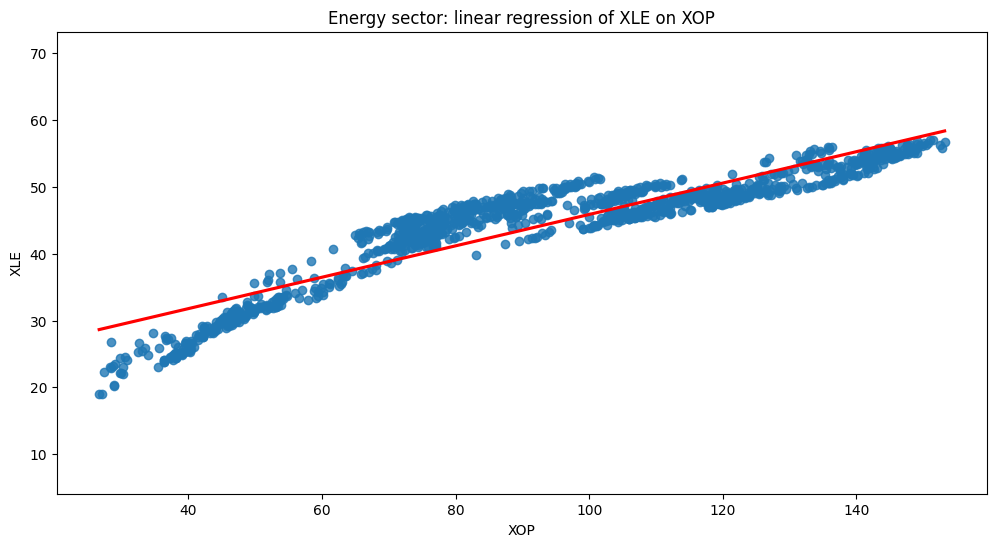

In [18]:
min_XOP = prices["XOP"].min()
max_XOP = prices["XOP"].max()
regr_plot_energy = sns.regplot(x='XOP', y='XLE', data=prices[["XLE", "XOP"]], x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
regr_plot_energy.axis('equal')
regr_plot_energy.set_title("Energy sector: linear regression of XLE on XOP")
plt.show()

In [19]:
# ADF test
adf_stat, pvalue, *_ = adfuller(spread_energy, regression='n') # no constant or trend term in test's regression
print(f"ADF statistic = {adf_stat:.3f},   p-value = {pvalue:.4f}")

ADF statistic = -2.306,   p-value = 0.0203


The regression graph above confirms the series are correlated, however the ADF test needs to be tweaked into excluding both constant and trend terms (leaving only lags terms) in order for it to yield a $p$-value $< 0.05$, indicating co-integration.

This difficulty is probably related to the break down of the spread between XOP and XLE happening in March 2020.

We suspect that a vanilla trading strategy which fails to include provisions to stop trading during high-volatility regimes, would underperform in comparison to a strategy which instead would include such provisions.
This pessimistic prediction of the performance of the vanilla pair trading strategy will be scrutinised in Step 2 of this report, where we will enhance it with the addition of a volatility regime-switching indicator.

For now, the pair strategy will

1. Calculate the standardised difference between the current $\text{spread}(t) = XLE(t) - \text{regressed } XLE(t)$ and the average $\overline{spread}(t - 63, \dots, t)$ from a rolling time window going back 3 months (63 business days). This is a time series across the whole timeframe 2017-22.
2. 
    1. Enter a long trade when the spread of residuals is two deviations less than the rolling mean
	2. Enter a short trade when the spread of residuals is two deviations more than the rolling mean
	3. Exit trades when the spread of residuals is within one deviation centred at the mean
3. Compute the cumulative Profits and Losses (PnL) for the pair strategy based on the indicator of mean reversion built at previous points 1. and 2.

In [20]:
# Signal
roll_window = 63 # trimestral
zscore_energy = (spread_energy - spread_energy.rolling(roll_window).mean()) / spread_energy.rolling(roll_window).std()
long_entry  = zscore_energy <= -2
short_entry = zscore_energy >=  2
exit        = zscore_energy.abs() < 0.5

position_energy = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_energy = pd.Series(position_energy, index=prices.index).ffill().where(~exit, 0).iloc[roll_window:]
position_energy = position_energy.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy.name = "Spread Position"
# position_energy

Below, we plot side by side 
- the series of the normalised residuals ($z$-score) from the regression
- a QQ graph showing the fit of quantiles of the normalised residuals against quantiles of the normal distribution. The red line indicates the ideal perfect fit to normal.

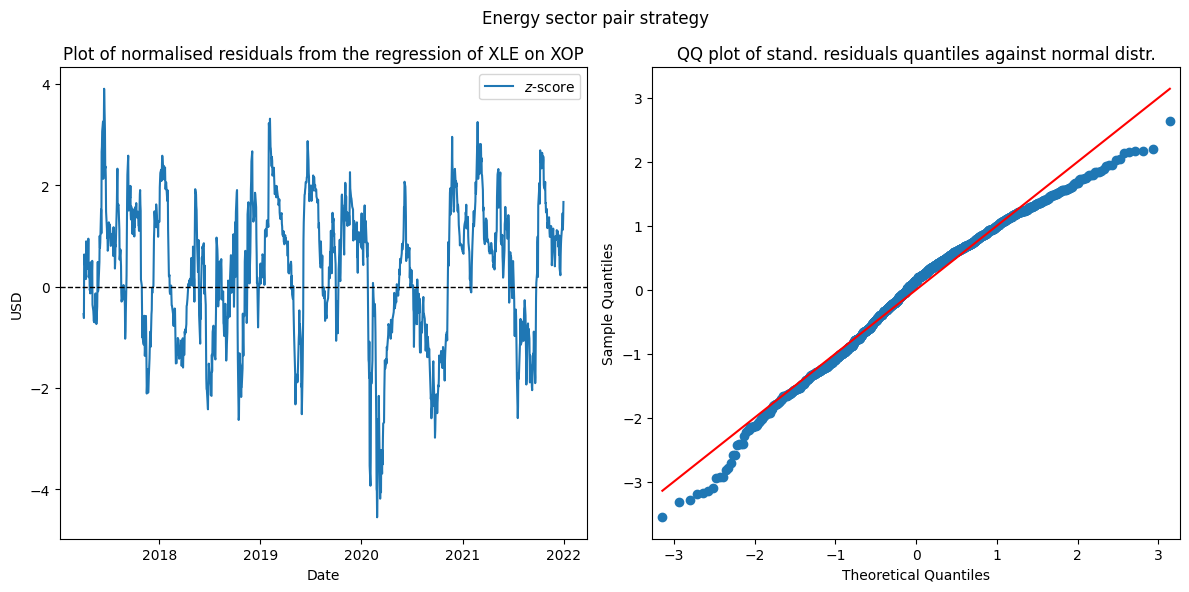

In [21]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(zscore_energy.index, zscore_energy, label="$z$-score")
ax[0].axhline(0, ls="--", color="k", lw=1)
ax[0].set_title("Plot of normalised residuals from the regression of XLE on XOP")
ax[0].set_ylabel("USD")
ax[0].set_xlabel("Date")
ax[0].legend()

#ax[1] = fig.add_subplot(1)
sm.graphics.qqplot(zscore_energy.dropna(), fit=True, line='s', ax=ax[1])
ax[1].set_title("QQ plot of stand. residuals quantiles against normal distr.")

plt.suptitle("Energy sector pair strategy")
plt.tight_layout()
plt.show()

The QQ plot above reveals a left (negative) skew of the standardised residuals with respect to the normal distribution: it shows an heavier left tail (more small values than expected) and a lighter right tail (less big values, hence left skew).

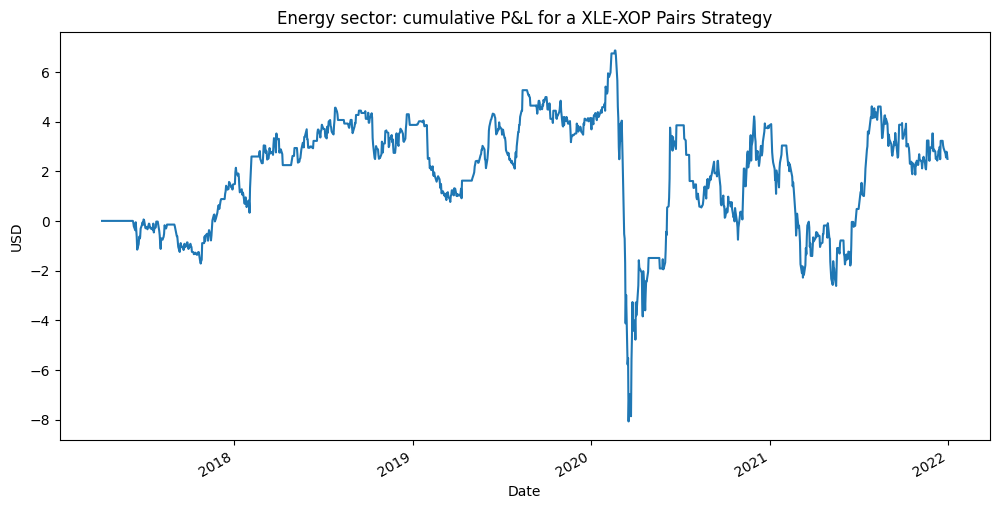

Annualised Sharpe for Energy sector pair strategy ≈ 0.09


In [22]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy.shift() * spread_returns
cum_pnl_energy = strategy_ret.cumsum()
cum_pnl_energy.name = "PnL Energy pair"

# Results
fig, ax = plt.subplots()
cum_pnl_energy.plot(ax=ax, title="Energy sector: cumulative P&L for a XLE-XOP Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_energy = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy:.2f}")

In [23]:
cum_pnl_energy.describe()

count    1195.000000
mean        1.883297
std         2.167426
min        -8.077564
25%         0.000000
50%         2.416954
75%         3.667873
max         6.863168
Name: PnL Energy pair, dtype: float64

The vanilla pair strategy for the Energy sector fails to emit timely signals when the Covid crisis struck in March 2020 and keeps buying up until the end of April 2020, causing a big drawdown that jeopardizes the profitability of the strategy.

#### Strategy 2: Gold ETFs

We proceed similarly with the Gold sector pair strategy:

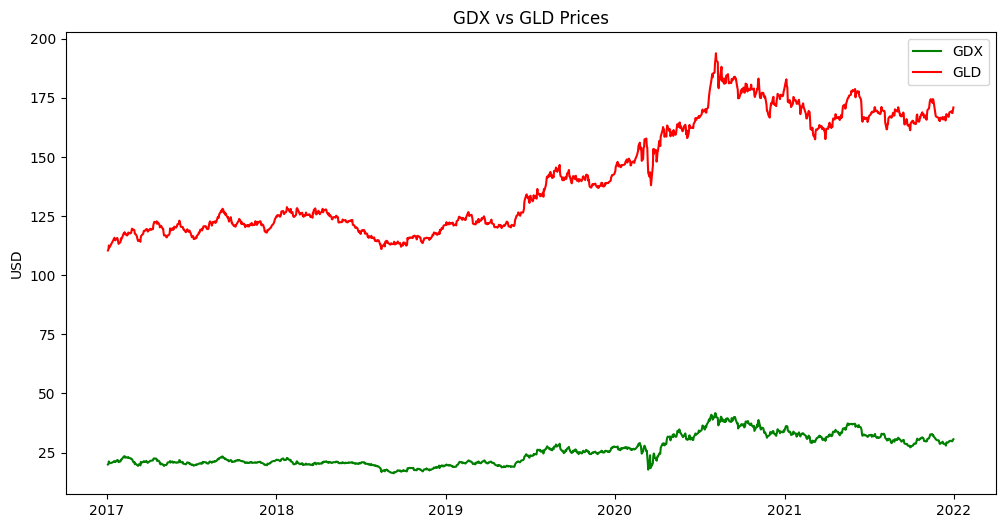

In [24]:
plt.plot(prices.index, prices["GDX"], 'g', label="GDX")
plt.plot(prices.index, prices["GLD"], 'r', label="GLD")
plt.title("GDX vs GLD Prices")
plt.legend()
plt.ylabel("USD")
plt.show()

In [25]:
# OLS regression and spread
y = prices["GDX"]
X = sm.add_constant(prices["GLD"])
model_gold = sm.OLS(y, X).fit()
alpha_gold, beta_gold = model_gold.params
spread_gold = y - (alpha_gold + beta_gold * prices["GLD"])
spread_gold.name = "Spread"
print("GDX on GLD Regression beta coefficient: ", beta_gold)

GDX on GLD Regression beta coefficient:  0.25860632283233287


The *hedge ratio* for this gold sector pair strategy is equal to the $\beta = 0.259$ coefficient of the regression of one ETF onto the other.

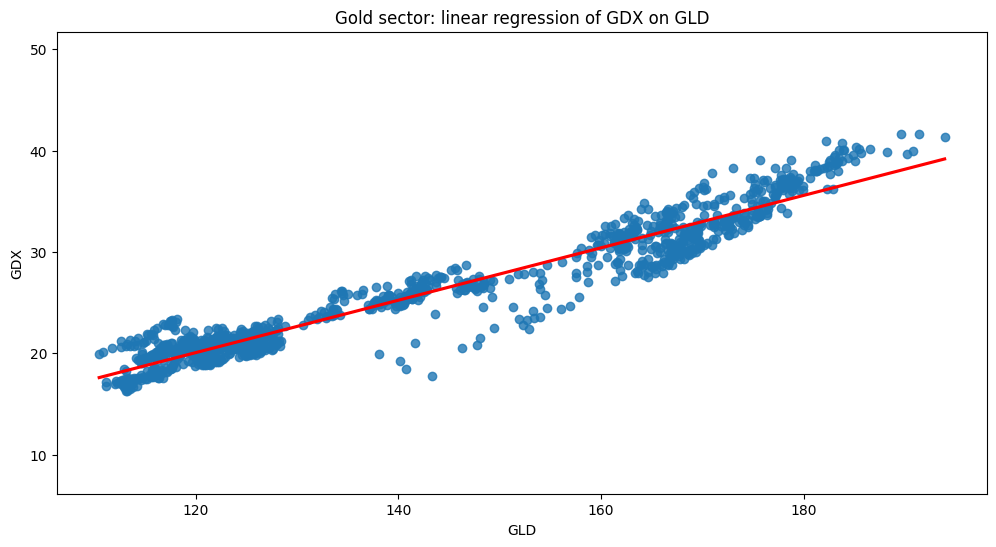

In [26]:
min_GLD = prices["GLD"].min()
max_GLD = prices["GLD"].max()
regr_plot_gold = sns.regplot(x='GLD', y='GDX', data=prices[["GDX", "GLD"]], x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
regr_plot_gold.axis('equal')
regr_plot_gold.set_title("Gold sector: linear regression of GDX on GLD")
plt.show()

In [27]:
# ADF test
adf_stat, pvalue, *_ = adfuller(spread_gold, regression='ct') # constant + trend term in test's regression
print(f"ADF statistic = {adf_stat:.3f},   p-value = {pvalue:.4f}")

ADF statistic = -3.924,   p-value = 0.0112


Here the ADF test easily yields $p$-value $< 0.05$ with constant and trend terms present in the regression, so the series keep being co-integrated throughout the time window 2017-22.
As such, we do not expect major repercussions on the PnL of the vanilla pair strategy for this sector, that are due to the Covid 2020 breakdown.

In [28]:
# Signal
roll_window = 63 # trimestral
zscore_gold = (spread_gold - spread_gold.rolling(roll_window).mean()) / spread_gold.rolling(roll_window).std()
long_entry  = zscore_gold <= -2
short_entry = zscore_gold >=  2
exit        = zscore_gold.abs() < 0.5

position_gold = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_gold = pd.Series(position_gold, index=prices.index).ffill().where(~exit, 0).iloc[roll_window:]
position_gold = position_gold.fillna(0)		# fills string of initial na (before first trade) to 0
position_gold.name = "Spread Position"
# position_gold

Below, we plot side by side 
- the series of the normalised residuals ($z$-score) from the regression
- a QQ graph showing the fit of quantiles of the normalised residuals against quantiles of the normal distribution. The red line indicates the ideal perfect fit to normal.

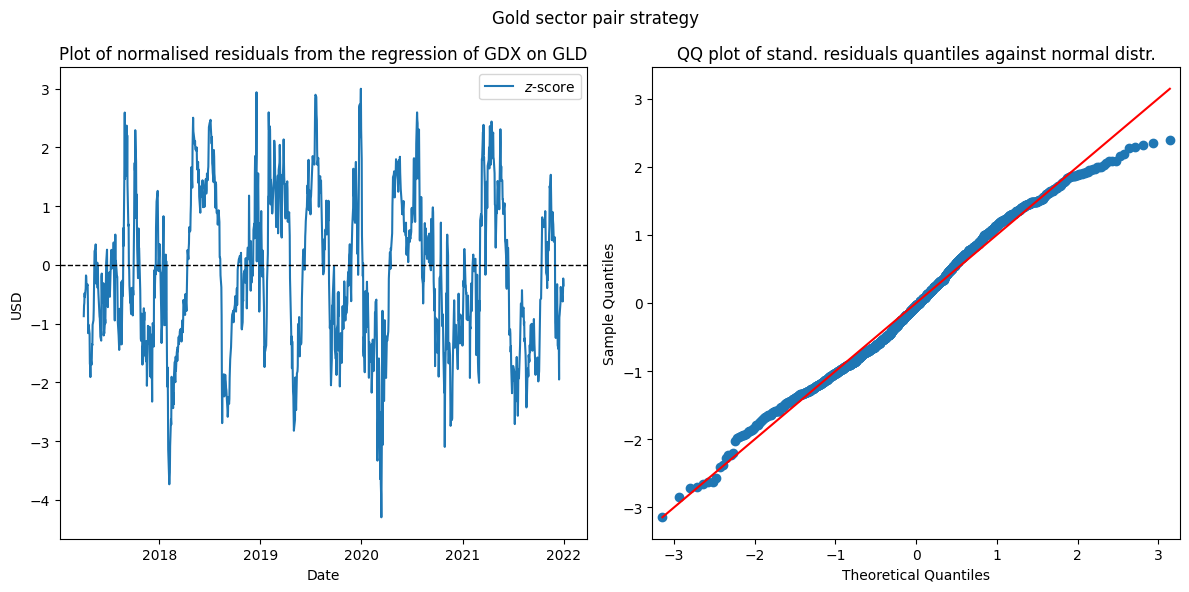

In [29]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(zscore_gold.index, zscore_gold, label="$z$-score")
ax[0].axhline(0, ls="--", color="k", lw=1)
ax[0].set_title("Plot of normalised residuals from the regression of GDX on GLD")
ax[0].set_ylabel("USD")
ax[0].set_xlabel("Date")
ax[0].legend()

#ax[1] = fig.add_subplot(1)
sm.graphics.qqplot(zscore_gold.dropna(), fit=True, line='s', ax=ax[1])
ax[1].set_title("QQ plot of stand. residuals quantiles against normal distr.")

plt.suptitle("Gold sector pair strategy")
plt.tight_layout()
plt.show()

The QQ plot above reveals a slight left (negative) skew of the standardised residuals with respect to the normal distribution: it shows a fairly regular left tail and a lighter right tail (less big values, hence left skew).

The cumulative returns of the pair strategy based on Gold ETFs, and its annualised Sharpe ratio:

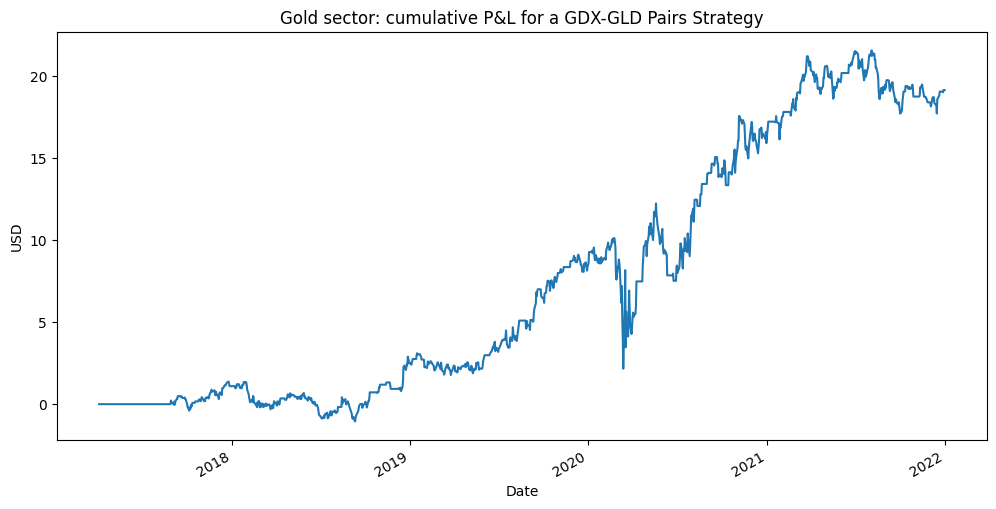

Annualised Sharpe for Gold sector pair strategy ≈ 0.69


In [30]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold.shift() * spread_returns
cum_pnl_gold = strategy_ret.cumsum()
cum_pnl_gold.name = "PnL Gold pair"

# Results
fig, ax = plt.subplots()
cum_pnl_gold.plot(ax=ax, title="Gold sector: cumulative P&L for a GDX-GLD Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_gold = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold:.2f}")

In [31]:
cum_pnl_gold.describe()

count    1195.000000
mean        7.484671
std         7.575273
min        -1.051649
25%         0.417105
50%         4.599447
75%        14.985606
max        21.549778
Name: PnL Gold pair, dtype: float64

#### Strategy 3: Technology ETFs

Lastly, the Technology sector pair strategy.

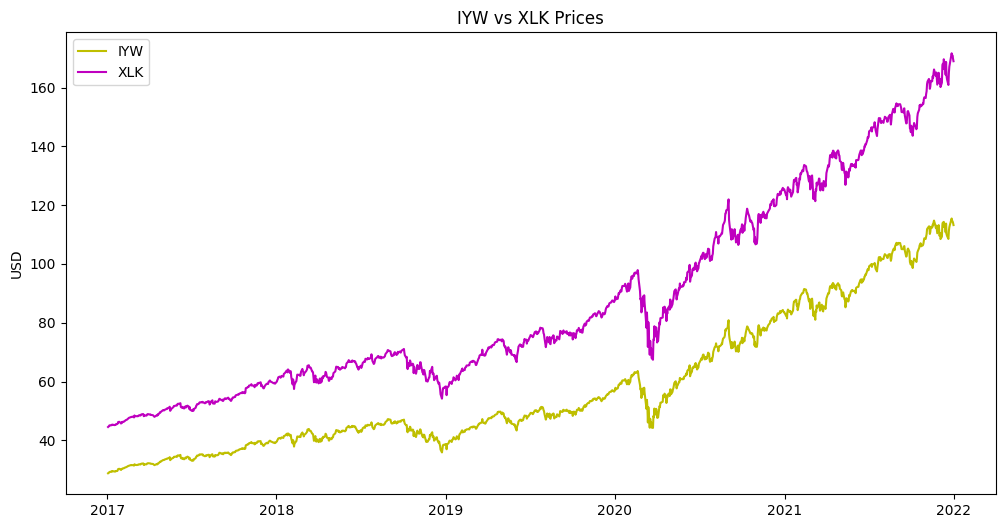

In [32]:
plt.plot(prices.index, prices["IYW"], 'y', label="IYW")
plt.plot(prices.index, prices["XLK"], 'm', label="XLK")
plt.title("IYW vs XLK Prices")
plt.legend()
plt.ylabel("USD")
plt.show()

In [33]:
# OLS regression and spread
y = prices["IYW"]
X = sm.add_constant(prices["XLK"])
model_tech = sm.OLS(y, X).fit()
alpha_tech, beta_tech = model_tech.params
spread_tech = y - (alpha_tech + beta_tech * prices["XLK"])
spread_tech.name = "Spread"
print("IYW on XLK Regression beta coefficient: ", beta_tech)

IYW on XLK Regression beta coefficient:  0.6933943020888851


The *hedge ratio* for this technology sector pair strategy is equal to the $\beta = 0.693$ coefficient of the regression.

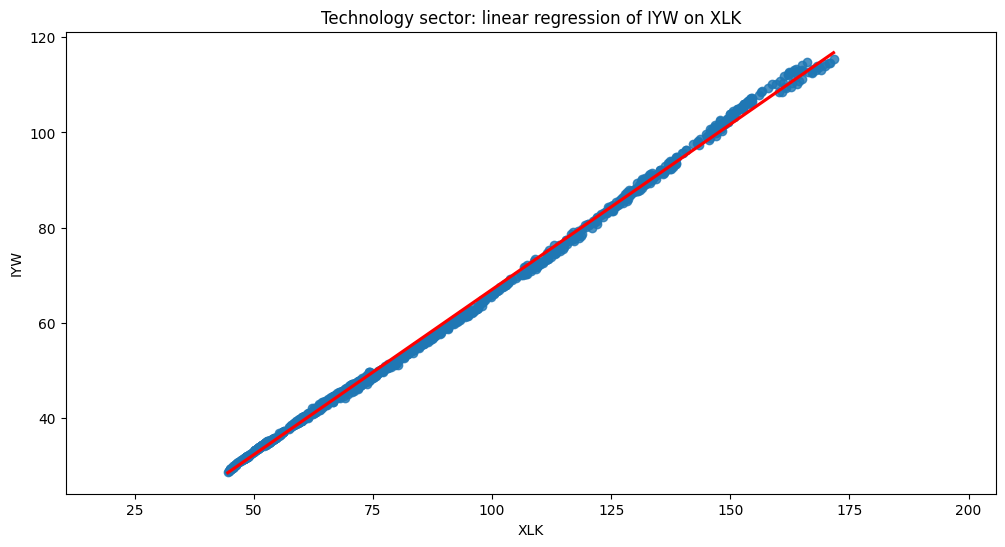

In [34]:
min_XLK = prices["XLK"].min()
max_XLK = prices["XLK"].max()
regr_plot_tech = sns.regplot(x='XLK', y='IYW', data=prices[["IYW", "XLK"]], x_ci="ci", marker="o", scatter=True, line_kws=dict(color="r"), ci=None)
regr_plot_tech.axis('equal')
regr_plot_tech.set_title("Technology sector: linear regression of IYW on XLK")
plt.show()

In [35]:
# ADF test
adf_stat, pvalue, *_ = adfuller(spread_tech, regression='n') # no constant or trend term in test's regression
print(f"ADF statistic = {adf_stat:.3f},   p-value = {pvalue:.4f}")

ADF statistic = -2.470,   p-value = 0.0131


The ADF test needs to discard the constant and trend terms in the regression in order to show $p$-value $< 0.05$, meaning the series co-integration is perhaps affected by the Covid crisis.

In [36]:
# Signal
roll_window = 63 # trimestral
zscore_tech = (spread_tech - spread_tech.rolling(roll_window).mean()) / spread_tech.rolling(roll_window).std()
long_entry  = zscore_tech <= -2
short_entry = zscore_tech >=  2
exit        = zscore_tech.abs() < 0.5

position_tech = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_tech = pd.Series(position_tech, index=prices.index).ffill().where(~exit, 0).iloc[roll_window:]
position_tech = position_tech.fillna(0)		# fills string of initial na (before first trade) to 0
position_tech.name = "Spread Position"
# position_tech

Below, we plot side by side 
- the series of the normalised residuals ($z$-score) from the regression
- a QQ graph showing the fit of quantiles of the normalised residuals against quantiles of the normal distribution. The red line indicates the ideal perfect fit to normal.

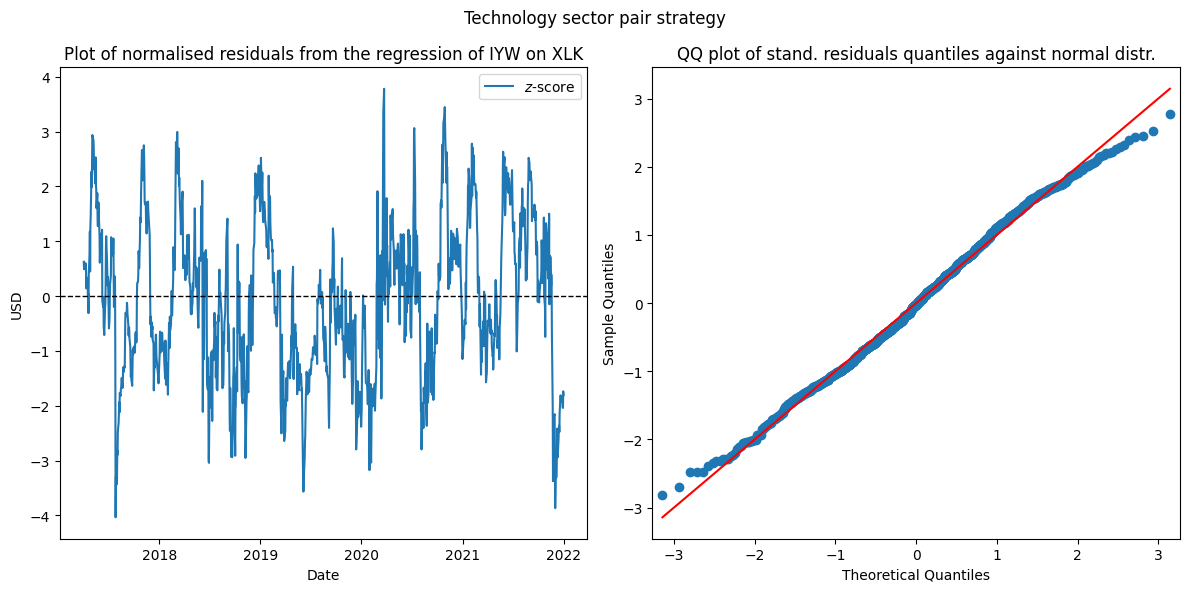

In [37]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(zscore_tech.index, zscore_tech, label="$z$-score")
ax[0].axhline(0, ls="--", color="k", lw=1)
ax[0].set_title("Plot of normalised residuals from the regression of IYW on XLK")
ax[0].set_ylabel("USD")
ax[0].set_xlabel("Date")
ax[0].legend()

#ax[1] = fig.add_subplot(1)
sm.graphics.qqplot(zscore_tech.dropna(), fit=True, line='s', ax=ax[1])
ax[1].set_title("QQ plot of stand. residuals quantiles against normal distr.")

plt.suptitle("Technology sector pair strategy")
plt.tight_layout()
plt.show()

The QQ plot above reveals a lightly tailed distribution of the standardised residuals with respect to the normal distribution: both ends of extreme values are less than expected in a normal distribution, while values around the mean are slightly overrepresented.

The cumulative returns of the pair strategy based on Technology ETFs, and its annualised Sharpe ratio:

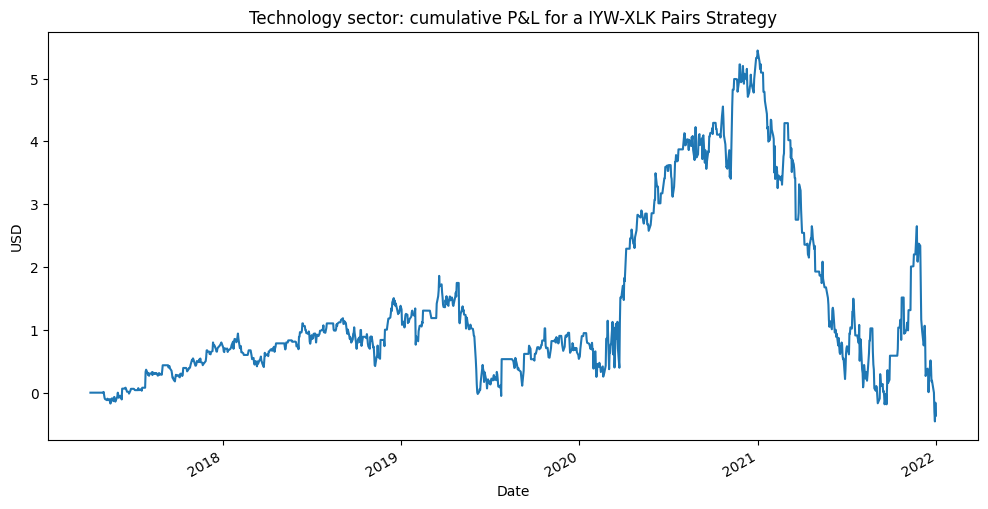

Annualised Sharpe for Technology sector pair strategy ≈ -0.03


In [38]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech.shift() * spread_returns
cum_pnl_tech = strategy_ret.cumsum()
cum_pnl_tech.name = "PnL Technology pair"

# Results
fig, ax = plt.subplots()
cum_pnl_tech.plot(ax=ax, title="Technology sector: cumulative P&L for a IYW-XLK Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_tech = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech:.2f}")

In [39]:
cum_pnl_tech.describe()

count    1195.000000
mean        1.397741
std         1.371248
min        -0.457949
25%         0.528365
50%         0.868409
75%         1.741977
max         5.448714
Name: PnL Technology pair, dtype: float64

PnL graph for the Technology pair strategy shows a countercyclical growth during the Covid crisis, which however is wholly erased by a catastrophic 2021 that sees the strategy consistently losing money.
This proceeds up to the point of having the series ending with a negative balance at the closing date of the timeframe considered.

#### Summary

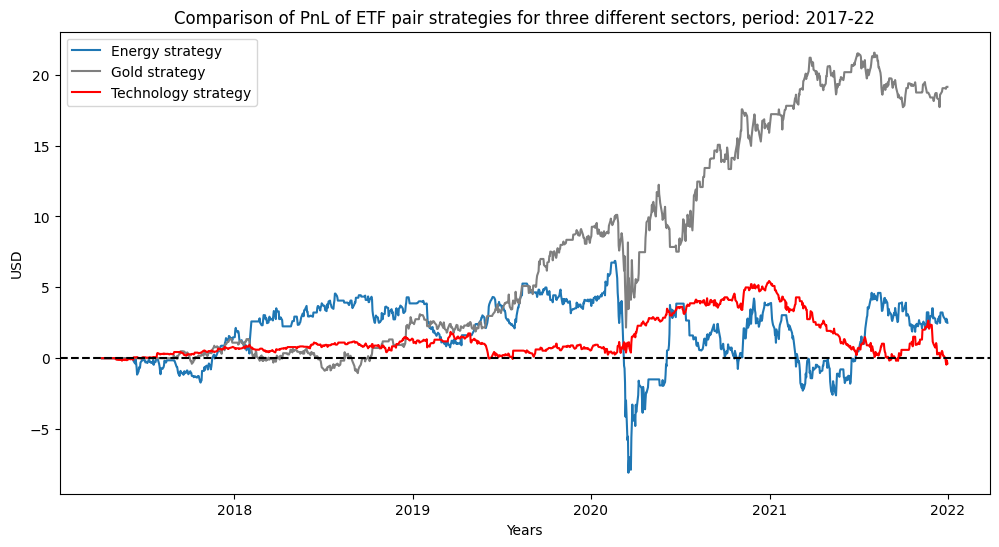

In [40]:
#fig, ax = plt.subplots()
plt.plot(cum_pnl_energy.index, cum_pnl_energy, label="Energy strategy")
plt.plot(cum_pnl_gold.index, cum_pnl_gold, 'tab:gray', label="Gold strategy")
plt.plot(cum_pnl_tech.index, cum_pnl_tech, 'r', label="Technology strategy")
plt.axhline(0, ls="--", color="black", lw=1.5)
plt.ylabel("USD")
plt.xlabel("Years")
plt.legend()
plt.title("Comparison of PnL of ETF pair strategies for three different sectors, period: 2017-22")

plt.show()

In [41]:
print("Annualised Sharpe Ratios")
print(f"Energy sector pair strategy ≈ {annual_sharpe_energy:.2f}")
print(f"Gold sector pair strategy ≈ {annual_sharpe_gold:.2f}")
print(f"Technology sector pair strategy ≈ {annual_sharpe_tech:.2f}")

Annualised Sharpe Ratios
Energy sector pair strategy ≈ 0.09
Gold sector pair strategy ≈ 0.69
Technology sector pair strategy ≈ -0.03


From the above graph and data comparing the three vanilla pair strategies, we can see that the time series which most effortlessly passed the ADF test on its residuals (Gold sector) easily outperforms the other two less co-integrated pair strategies.

### Foundational Analysis, part C: identify volatility regimes in SPY using a Markov Switching AutoRegressive (MS-AR) model

For starters, we inspect the statistical properties of SPY returns for the 2017-22 timeframe and then plot the series on a graph.

In [42]:
print("Main statistical features of the time series for daily SPY returns, 2017-22:")
print(rets["SPY"].describe())

Main statistical features of the time series for daily SPY returns, 2017-22:
count    1258.000000
mean        0.000663
std         0.011944
min        -0.115886
25%        -0.002941
50%         0.000920
75%         0.005883
max         0.086731
Name: SPY, dtype: float64


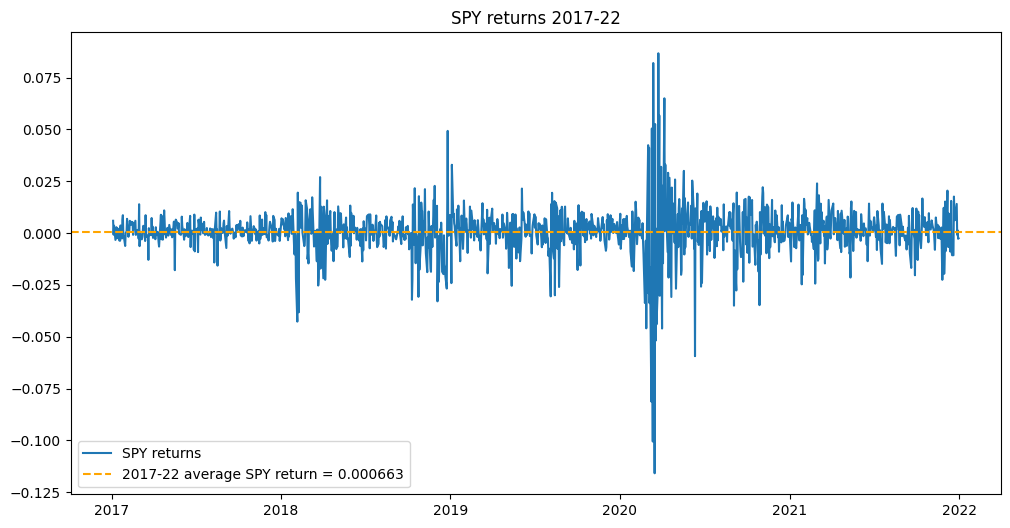

In [43]:
plt.plot(rets["SPY"], label="SPY returns")
plt.axhline(rets["SPY"].mean(), ls="--", color="orange", lw=1.5, label="2017-22 average SPY return = 0.000663") #rets["SPY"].mean()
plt.legend(loc="lower left")
plt.title("SPY returns 2017-22")

plt.show()

We can see from the graph above that the SPY time series is stationary and thus mean-reverting, with variable volatility appearing in persistent regimes.
The time series is heteroscedastic: bouts of high volatility tend to keep going for a while, before subsuming.

We expect that a Markov Switching Auto-Regressive (MS-AR) model could be fit to the data with some success.
Exploiting the heteroscedasticity of the SPY series, the model will be switching between a low volatility *calm* regime, and a high volatility *stressed* regime.
For simplicity, the autoregression of the model will be of order 1, with the current observation $y_t$ dependent solely on the previous one $y_{t-1}$:

$$
y_t = \mu_{S_t} + \phi (y_{t_1} - \mu_{S_{t-1}}) + \varepsilon_t
$$

with $S_t = \{1, 2\}$ being the Markov regime at time $t$, $\mu_{S_t}$ being the average value of all $y$ falling under regime $S_t$ up to instant $t$, $\phi (\text{drift})$ being the peculiar expression of mean reversion for the particular model adopted, and $\varepsilon$ being the associated normal error.

$S_t$ switches between calm and stressed regimes according to a transition matrix:

$$
P(S_t | S_{t-1}) = \begin{bmatrix}
    p_{00} & p_{01}\\
	p_{10} & p_{11}
\end{bmatrix}
$$

where $p_{ij}$ is the probability for $y_t$ of switching from regime $S_{t-1} = i$ to regime $S_t = j$.

The mean-reverting and volatility-clustering properties of the SPY returns series lend themself to be represented by an Ornstein-Uhlenbeck (OU) process, which mathematical expression is

$$
d y_t = \kappa (\mu - y_t) dt + \sigma dW_t
$$

where $\kappa$ is the speed of the mean reversion and $\sigma$ is the volatility of the Wiener process $d W_t$.
A solution for the UO process above exists in closed form, and after being discretised in temporal steps of length $\Delta t$, it takes the following form:

$$
y_{t + \Delta t} = \mu + (y_t - \mu) e^{- \kappa \Delta t} + \varepsilon_{t + \Delta t}
$$

with error $\varepsilon$ normally distributed:

$$
\varepsilon_{t + \Delta t} \sim N \left( 0, \frac{\sigma^2}{2 \kappa} (1 - e^{- 2 \kappa \Delta t}) \right)
$$

There is an out-of-the-box rendition of a MS-AR model within the *statsmodels* package for python, the `MarkovAutoregression` class.

In [44]:
mod_spy = sm.tsa.MarkovAutoregression(rets["SPY"], k_regimes=2, order=1, trend='c', switching_ar=True, switching_variance=True)

We set the `MarkovAutoregression` object to follow a simple AR(1) process

$$
y_t = \alpha + \beta y_{t-1} + \varepsilon_t
$$

where we need to calibrate coefficients $\alpha$ and $\beta$ according to the parameters in our UO process for SPY returns.

Comparing formulas for the generic UO and AR(1) processes, it follows that

\begin{align}
\alpha =& \mu (1 - e^{- \kappa \Delta t}) = \mu (1 - \beta)\\
\beta =& e^{- \kappa \Delta t}
\end{align}

We start from inferring a very rough and qualitative estimation for the half-time of mean-reversion $\tau_{1/2}$, from visual inspection of the graph of SPY returns.

For starters, $\tau_{1/2}$ is defined as

$$
\tau_{1/2} = \frac{\log{2}}{\kappa}
$$

with $\kappa$ being the reversion speed parameter in the UO process.

From the graph of SPY returns, we decide to set

| | calm regime | stressed regime |
| :---: | :---: | :---: |
| $\tau_{1/2}$ | $10.5$ | $21$ |

Afterwards, it is easy to extract $\kappa$ from the expression of $\tau_{1/2}$.

Since we have daily data for SPY, our $\Delta t = \frac{1}{252}$, expressed in terms of a business year.

Knowing $\Delta t$ and $\kappa$ for both regimes allows us to determine starting values for $\alpha$ and $\beta$, to be fed to the `MarkovAutoregression` object.

This object also needs starting values for the volatility $\sigma$ and unconstrained probabilities of transition $p$ for both Markov regimes considered.
While the former can be estimated visually, the latter is prescribed by *statsmodels* to follow an inverse logit form:

$$
\text{logit}^{-1}(p) = \frac{e^p}{1 + e^p}
$$

We choose probability to persist in the same regime $p = [0.9, 0.5]$ for calm and stressed regime, respectively.
We feed the model with the $\text{logit}^{-1}(p)$ values, computed according to the above-mentioned formula.

In [45]:
# halflife
tau_days = np.array([10.5, 21]) # SPY returns half-revert in 10 days when low vol, in 21 when high vol
business_year_in_days = 252
tau = tau_days / business_year_in_days
# UO's mean reversion adapted to AR(1)'s beta
log2 = np.log(2)
kappa = log2 / tau
beta = np.exp(-kappa / business_year_in_days)

mu = [0.0005, -0.0010]
alpha = mu * (1 - beta)

sigma = [0.008, 0.02]

# rough estimation of logit^-1(transition probabilities)
P = np.array([0.9, 0.5])
logit = np.exp(P)/(1 + np.exp(P))

In [46]:
# a = dict({"logit" : logit, "alpha" : alpha, "sigma" : sigma, "beta" : beta})
# a

Thus we can list below the numerical starting values for the parameters within the `MarkovAutoregression` object:

| starting value | calm regime | stressed regime |
|:---:|:---:|:--:|
| $\text{logit}(p)$ | 0.711 | 0.622 |
| $\alpha$ | 3.19e-5 | -3.25e-5 |
| $\sigma$ | 0.008 | 0.02 |
| $\beta$ | 0.936 | 0.968 |

The `MarkovAutoregression` object also accepts boundary values not to trespass during the analysis.

We think the following are realistic constraints:

| bounds | lower | upper |
|:---:|:---:|:--:|
| $\text{logit}(p)$ | 0.25 | 0.931 |
| $\alpha$ | -0.001 | 0.1 |
| $\sigma$ | 0.001 | $\infty$ |
| $\beta$ | 0.5 | 1.3 |

In [47]:
# parameter layout:
#  0,1   → alpha_0, alpha_1          (intercepts)
#  2,3   → phi_0, phi_1          (AR(1) beta's)
#  4,5   → sigma_0, sigma_1        (variances)
#  6,7   → unconstrained elements of P (logit‑scale)

start = mod_spy.start_params.copy()
start[:2] = logit       # logit(P)       # mu guesses: calm 20 bp, stress 200 bp
start[2:4] = alpha  # mu          # beta guesses: kappa approx 2.3 /yr vs 1.0 /yr
start[4:6] = np.square(sigma)           # sigma guesses
# logit(P00) ~ 2.5  -> P00 approx 0.92 ; logit(P11) ~ 0   -> P11 approx 0.5
start[6:8] = beta  # beta

# bounds:   alpha ≥ 0,   0.70 <= beta <= 0.95,   sigma ≥ 1e‑3,   transition logits free
b = [(0.25, 0.931), (0.25, 0.931), #(0.5, 0.731), (0.5, 0.731), # P         # mu
	(-0.001, 0.1), (-0.001, 0.1), #(-0.01, 0.01), (-0.01, 0.01), # mu   # beta
	(1e-3, 1e6), (1e-3, 1e6),    # sigma
	(0.50, 1.3), (0.50, 1.3)]  #beta  # logits of P

np.random.seed(1234)
spy_markov_results = mod_spy.fit(start_params=start, bounds=b, method="bfgs", maxiter=500, search_reps=20) # bounds=b,

In [48]:
print( spy_markov_results.summary() )

                         Markov Switching Model Results                         
Dep. Variable:                      SPY   No. Observations:                 1257
Model:             MarkovAutoregression   Log Likelihood                4238.064
Date:                  Sat, 20 Sep 2025   AIC                          -8460.128
Time:                          22:32:20   BIC                          -8419.036
Sample:                               0   HQIC                         -8444.685
                                 - 1257                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -1.255      0.210      -0.003       0.001
sigma2         0.0004   3.91e-05    

The simulation results above indicate that while transition probabilities estimations might be reliable, coefficient $\alpha$ for the stressed regime, and $\beta$ for the calm regime are obtained with non-negligible incertitude.

Below, the parameters for the MS-AR model as computed inside the `MarkovAutoregression` object; *const* stands for $\alpha$, and *ar.L1* for $\beta$.

In [49]:
spy_markov_results.params

p[0->0]      0.936021
p[1->0]      0.023229
const[0]    -0.001159
const[1]     0.001359
sigma2[0]    0.000416
sigma2[1]    0.000029
ar.L1[0]    -0.261289
ar.L1[1]    -0.046084
dtype: float64

In the following, we plot the probabilities of being in either regime.

We can easily recognise that the bout of high volatility due to the Covid pandemic - from March 2020 through most of the year - is correctly estimated, including a brief recovery period which occurred during a relatively disease-free summer '20.

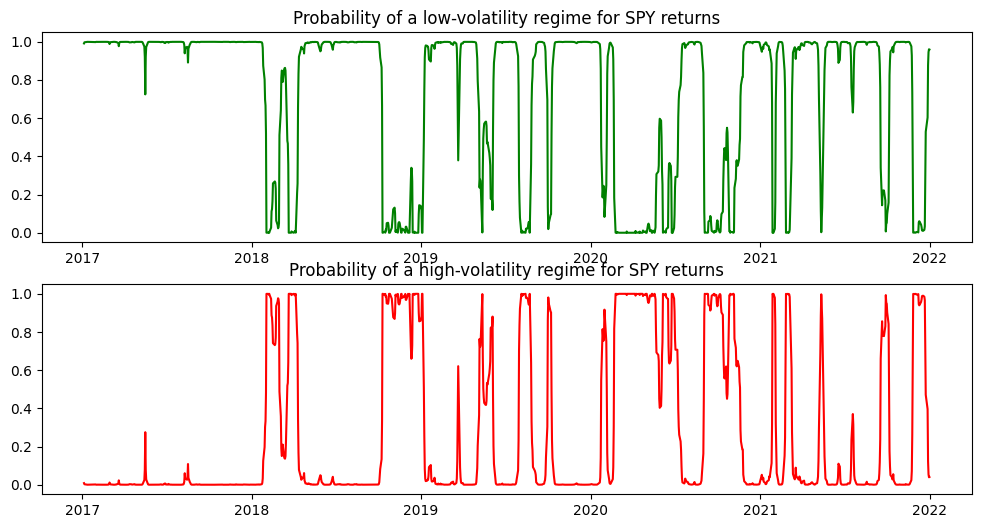

In [50]:
fig, axes = plt.subplots(2)

ax = axes[0]
ax.plot(spy_markov_results.smoothed_marginal_probabilities[1],'g')
ax.set(title="Probability of a low-volatility regime for SPY returns")

ax = axes[1]
ax.plot(spy_markov_results.smoothed_marginal_probabilities[0],'r')
ax.set(title="Probability of a high-volatility regime for SPY returns")
plt.show()

In [51]:
print("Average duration of each regime:")
print(f"Calm regime: {spy_markov_results.expected_durations[1]:.3f}  days\nStressed regime:  {spy_markov_results.expected_durations[0]:.3f} days")

Average duration of each regime:
Calm regime: 43.050  days
Stressed regime:  15.630 days


Average duration for the calm regime being nearly three times that of the stressed regime, this confirms our expectations.

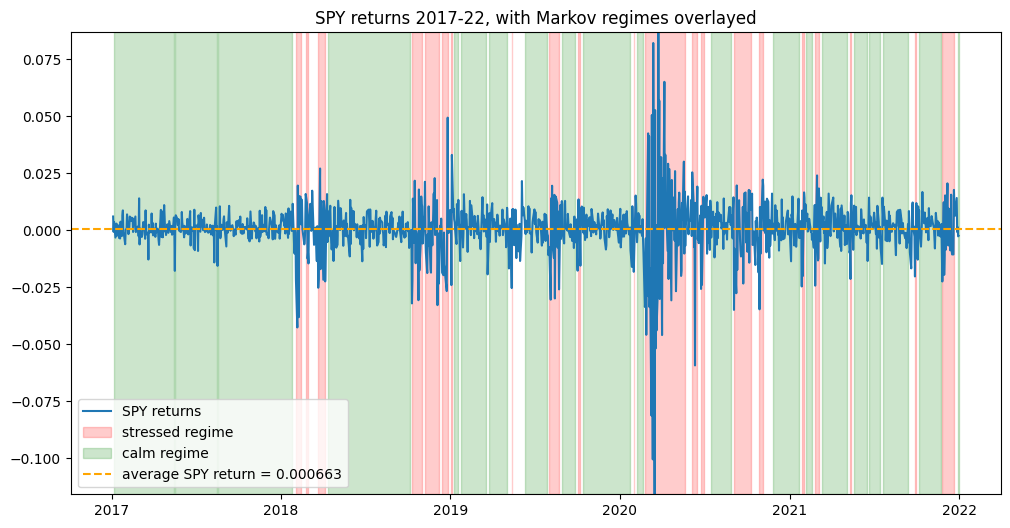

In [52]:
min_spy = np.min(rets["SPY"])
max_spy = np.max(rets["SPY"])
overlay = spy_markov_results.smoothed_marginal_probabilities[0] #* max_spy
overlay_g = spy_markov_results.smoothed_marginal_probabilities[1]

plt.plot(rets["SPY"], label="SPY returns")
plt.fill_between(overlay.index, min_spy, max_spy, where=overlay.values > 0.9, color="r", alpha=0.2, label="stressed regime")
plt.fill_between(overlay_g.index, min_spy, max_spy, where=overlay_g.values > 0.9, color="g", alpha=0.2, label="calm regime")
plt.axhline(rets["SPY"].mean(), ls="--", color="orange", lw=1.5, label="average SPY return = 0.000663")

plt.ylim(min_spy, max_spy)
plt.legend(loc="lower left")
plt.title("SPY returns 2017-22, with Markov regimes overlayed")

plt.show()

In the graph above, we overlay the Markov regimes on the SPY returns.

It can clearly be seen that the MS-AR model - as calibrated throughout this section - is successful in assigning the many periods of volatility clustering recorded during years 2017-22 to the correct regime.

## Step 2
### Describe the complete pair strategy adopted, composed of: (a) a baseline strategy based on the co-integrated spread of the chosen ETF pair trade, and (b) an added volatility regime-switching indicator, that activates the baseline strategy only when within the low-volatility regime.

The pair trading strategy illustrated in this report consists in identifying ETFs belonging to the same economic sector, covering similar assets, and replicating similar indices.
Given the criteria with which they were chosen, these ETFs should theoretically respond in a synchronised way to the vagaries of the markets.

In the jargon of Econometrics, this observation can be associated with the concept of two time series being *cointegrated*.
Cointegration is a more stringent condition than correlation: it prescribes the series to not just move with the same trend, but also to keep their distance (difference of values at the same position in the time series) within a certain band.
Given this definition, it seems then logical to associate cointegration with the notion of mean-reversion of a time series, and hence, to its stationarity.
In literature, there exist six statistical tests that can be performed on a pair of time series, to verify whether they are co-integrated.

In this report, we have resorted to the Engle-Granger test in previous Section 1.b, to check for cointegration of three pairs of ETFs belonging to the energy, gold and technology sectors.
This test regresses one of the series, using the other one as exogenous variable.
The residuals of the linear regression are then checked for stationarity, which is attained in the absence of unit roots.
The stationarity test we used in the previous section is the augmented Dickey-Fuller test, which rejects the null hypothesis of non-stationarity if the $p$-value of the associated Dickey-Fuller statistic is $< 0.05$.
Success of the ADF test on the *residuals* of the regression (spread) also allows to define the two original time series as cointegrated in the Engle-Granger sense. 

A pair trading strategy based on two cointegrated price series would exploit the expected stationarity - hence mean reversion of their spread - in case their spread on the markets strays outside of the expected band of mean reversion, breaching either the negative or the positive threshold.
This is seen as an anomaly for cointegrated time series, one that is expected to quickly retreat back within the accepted band of mean reversion for the series spread.

However, like correlation, cointegration between assets might radically break down and reconfigure in times of economic crisis.
In Section 1.c, we have identified two volatility regimes within the financial markets, based on the evolution of SPY for the period 2017-22.

Here, we upgrade the pair trading strategy already sketched in Section 1.b, with an added indicator of high-volatility regime in the markets.
When we enter a period of high volatility in the markets, one that could potentially turn into a fully fledged crisis where our pair cointegration might break down, the indicator activates.
In this case, the pair strategy is then directed to relinquish taking any position in the two ETFs composing the pair, until the high-volatility regime subsumes.

This expedient helps the strategy to avoid investing in periods when the cointegration relation, which lies at the basis of pair trading, might not hold, and thus the original vanilla pair strategy would be no better than randomly betting on the markets, and would most likely result in realised losses.

#### Description of the volatility regime-switching indicator

Here we employ code and results from Section 1.c to construct the volatility-regime-switching indicator.

From that section, we know that the Markov switching regression model is built in Python with the `MarkovAutoregression` class in *statsmodels*.
The class is fed initial state and boundary limits to its inner optimisation algorithm, from observation of the time series of SPY during the timeframe of reference (as already described in Section 1.c).

The class can output the smoothed probabilities that each regime has of actually happening during the timeframe.
*Smoothed*, as opposed to *filtered* probabilities, are computed for each time point $t$ using a larger number of neighbouring points, hence giving a more regular appearance than filtered probabilities, which are more locally restricted.

Our high volatility regime-switching indicator $I_{h \sigma}$ is derived from the smoothed probabilities of high volatility, $p_{h \sigma,\,\text{smooth}}$, by switching on the signal when smoothed probabilities of high vol are $p_{h \sigma,\,\text{smooth}} \geq 0.9$.

$$
I_{h \sigma} = \begin{cases}
    1 & p_{h \sigma,\,\text{smooth}} \geq 0.9\\
	0 & p_{h \sigma,\,\text{smooth}} < 0.9
\end{cases}
$$

We plot $I_{h \sigma}$ in the graph below.

In [53]:
# b add volatility-switch indicator to the strategy
# from step 1c
mod_spy = sm.tsa.MarkovAutoregression(rets["SPY"], k_regimes=2, order=1, trend='c', switching_ar=True, switching_variance=True)

# halflife
tau_days = np.array([10.5, 21]) # SPY returns half-revert in 10 days when low vol, in 21 when high vol
business_year_in_days = 252
tau = tau_days / business_year_in_days
# UO's mean reversion adapted to AR(1)'s beta
log2 = np.log(2)
kappa = log2 / tau
beta = np.exp(-kappa / business_year_in_days)

mu = [0.0005, -0.0010]
alpha = mu * (1 - beta)

sigma = [0.008, 0.02]

# rough estimation of logit^-1(transition probabilities)
P = np.array([0.9, 0.5])
logit = np.exp(P)/(1 + np.exp(P))

start = mod_spy.start_params.copy()
start[:2] = logit       # logit(P)       # mu guesses: calm 20 bp, stress 200 bp
start[2:4] = alpha  # mu          # beta guesses: kappa approx 2.3 /yr vs 1.0 /yr
start[4:6] = np.square(sigma)           # sigma guesses
# logit(P00) ~ 2.5  -> P00 approx 0.92 ; logit(P11) ~ 0   -> P11 approx 0.5
start[6:8] = beta  # beta

# bounds:   alpha ≥ 0,   0.70 <= beta <= 0.95,   sigma ≥ 1e‑3,   transition logits free
b = [(0.25, 0.931), (0.25, 0.931), #(0.5, 0.731), (0.5, 0.731), # P         # mu
	(-0.001, 0.1), (-0.001, 0.1), #(-0.01, 0.01), (-0.01, 0.01), # mu   # beta
	(1e-3, 1e6), (1e-3, 1e6),    # sigma
	(0.50, 1.3), (0.50, 1.3)]  #beta  # logits of P

np.random.seed(1234)
spy_markov_results = mod_spy.fit(start_params=start, bounds=b, method="bfgs", maxiter=500, search_reps=20)

In [54]:
# high vol regime indicator to be used inside pair strategy
switch_high_vol = spy_markov_results.smoothed_marginal_probabilities[0] > 0.9
# switch_high_vol 

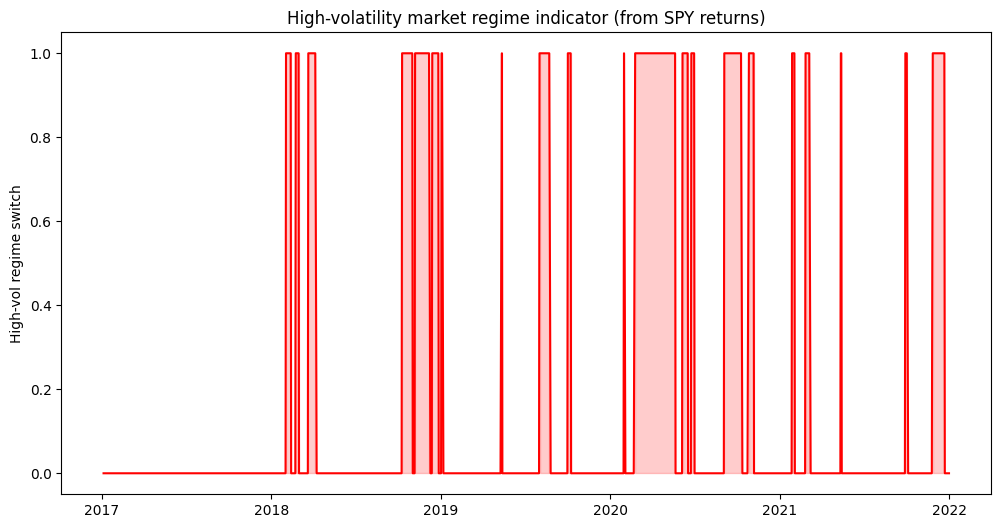

In [55]:
#fig, axes = plt.subplots(2)

# ax = axes[0]
# ax.plot(spy_markov_results.smoothed_marginal_probabilities[1],'g')
# ax.set(title="Probability of a low-volatility regime for SPY returns")

plt.plot(switch_high_vol,'r')
plt.fill_between(switch_high_vol.index, 0, 1, where=switch_high_vol.values == 1, color="r", alpha=0.2)
plt.title("High-volatility market regime indicator (from SPY returns)")
plt.ylabel("High-vol regime switch")
plt.show()

We note here that by both

- adopting as indicator the high volatility regime, instead of the low volatility one, and
- setting a high threshold at $0.9$ for indicator activation,

we create a more aggressive investment strategy, as this limits the 'stop trading' order only to instances of very high volatility regime.

Choosing to operate the pair strategy only under low volatility regimes, instead of directly excluding operations during high volatility bouts, would have led to a more defensive strategy.
Same can be said if we were still to employ the high volatility indicator, but with a lower threshold of activation.

We now apply the vol regime-switching pair strategy just described, to the three pairs of ETFs belonging to the sectors of Energy, Gold, and Technology.

#### Strategy 1: Energy ETFs

The vanilla strategies will differ from those sketched in Section 1.b, in that the condition to exit positions is no more triggered by

$$
\left| z_{\text{spread}} \right| < 0.5
$$

that is, the $z$-score of pair spread $z_{\text{spread}}$ should lay in a band $\pm 0.5$ around $0$.

Now, as new exit-trade condition, the $z$-score will have to lie in a tighter band $\pm 0.1$ around $0$, and in addition, as a second exit-trade condition, a trade position is going to be abandoned when the $z$-score of the pair spread changes sign from the previous observation:

\begin{align}
    z_{\text{spread}}(t) \cdot z_{\text{spread}}(t-1) & < 0\\	
	\left| z_{\text{spread}} \right| & < 0.1
\end{align}

The long and short trading thresholds stay the same, respectively:

$$
\begin{cases}
    z_{\text{spread}}  \leq -2 & \text{enter long}\\	
	z_{\text{spread}}  \geq 2 & \text{enter short}
\end{cases}
$$

In [56]:
# OLS regression and spread
y = prices["XLE"]
X = sm.add_constant(prices["XOP"])
model_energy = sm.OLS(y, X).fit()
alpha_energy, beta_energy = model_energy.params
spread_energy = y - (alpha_energy + beta_energy * prices["XOP"])
spread_energy.name = "Spread"
# print("XLE on XOP Regression beta coefficient: ", beta_energy)

In [57]:
# a. baseline strategy
roll_window = 63 # trimestral
zscore_energy = (spread_energy - spread_energy.rolling(roll_window).mean()) / spread_energy.rolling(roll_window).std()
long_entry  = zscore_energy <= -2
short_entry = zscore_energy >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_energy) != np.sign(zscore_energy.shift()) #or (zscore_energy.abs() < 0.1) #zscore_energy.abs() < 0.5
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_energy.abs() < 0.1)

position_energy_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_energy_no_switch = pd.Series(position_energy_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_energy_no_switch = position_energy_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy_no_switch.name = "Spread Position"
# position_energy

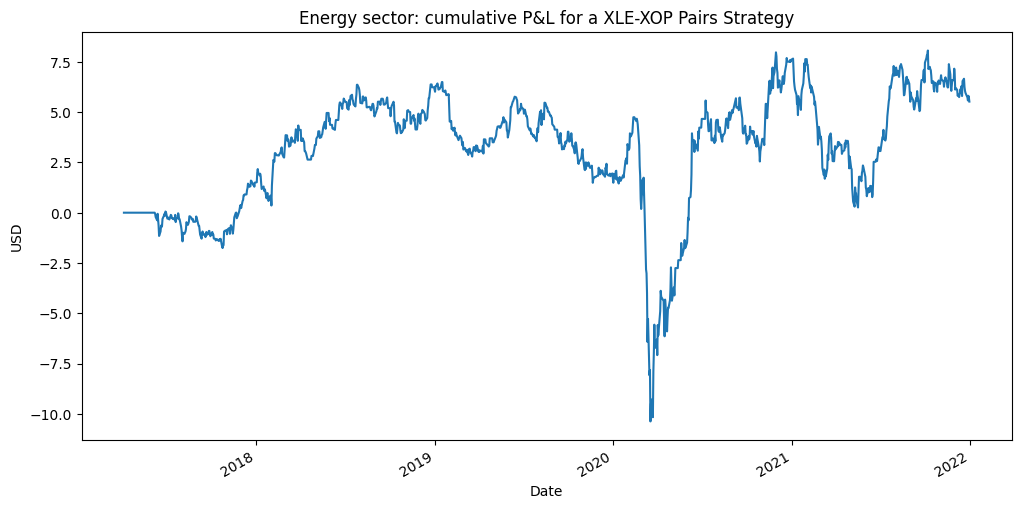

Annualised Sharpe for Energy sector pair strategy ≈ 0.19


In [58]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy_no_switch.shift() * spread_returns
cum_pnl_energy_no_switch = strategy_ret.cumsum()
cum_pnl_energy_no_switch.name = "PnL Energy pair"

# Results
fig, ax = plt.subplots()
cum_pnl_energy_no_switch.plot(ax=ax, title="Energy sector: cumulative P&L for a XLE-XOP Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_energy_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy_no_switch:.2f}")

With the new exit trade condition, the annualised Sharpe ratio grows to $0.19$ from $0.09$ in Section 1.b.

In the following, we derive the pair strategy with added regime switching indicator.

In [59]:
# apply vol switch to trading strategy 
position_energy_with_switch = position_energy_no_switch.where(~switch_high_vol, 0)

#position_energy_with_switch = position_energy_with_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_energy_with_switch.name = "Spread Position"
# position_energy_with_switch

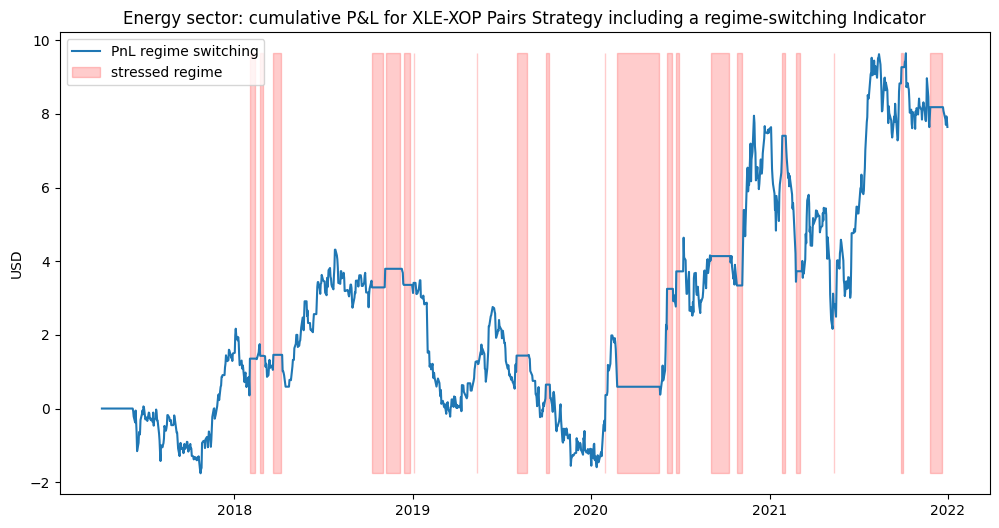

Annualised Sharpe for Energy sector pair strategy ≈ 0.39


In [60]:
# Strategy returns
spread_returns = spread_energy.iloc[roll_window:].diff()
strategy_ret = position_energy_with_switch.shift() * spread_returns
cum_pnl_energy_with_switch = strategy_ret.cumsum()
cum_pnl_energy_with_switch.name = "PnL Energy pair"

min_pnl = cum_pnl_energy_with_switch.min()
max_pnl = cum_pnl_energy_with_switch.max()
# Results
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Energy sector: cumulative P&L for XLE-XOP Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_energy_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Energy sector pair strategy ≈ {annual_sharpe_energy_with_switch:.2f}")

We observe the regime switching indicator to be a beneficial add-on to the pair strategy, increasing the annualise Sharpe ratio from $0.19$ to $0.39$.

We aggregate the vanilla and the regime switching strategy in the graph below for comparison.

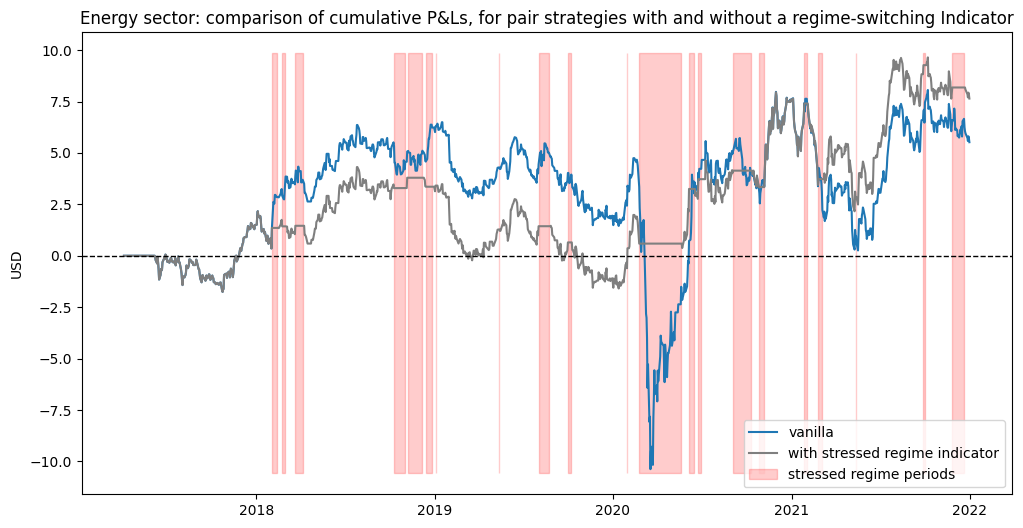

In [61]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_energy_with_switch.min(), cum_pnl_energy_no_switch.min())
max_pnl = max(cum_pnl_energy_with_switch.max(), cum_pnl_energy_no_switch.max())

#plt.plot(cum_pnl_energy.index, cum_pnl_energy)
plt.plot(cum_pnl_energy_no_switch.index, cum_pnl_energy_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Energy sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="lower right")

plt.show()

It is remarkable that the improved pair strategy with indicator is able to completely avoid the big drawdown experienced by the vanilla strategy in the first quarter of 2020.

#### Strategy 2: Gold ETFs

We apply the strategy to the Gold sector ETFs.

In [62]:
# OLS regression and spread
y = prices["GDX"]
X = sm.add_constant(prices["GLD"])
model_gold = sm.OLS(y, X).fit()
alpha_gold, beta_gold = model_gold.params
spread_gold = y - (alpha_gold + beta_gold * prices["GLD"])
spread_gold.name = "Spread"

In [63]:
# baseline strategy
roll_window = 63 # trimestral
zscore_gold = (spread_gold - spread_gold.rolling(roll_window).mean()) / spread_gold.rolling(roll_window).std()
long_entry  = zscore_gold <= -2
short_entry = zscore_gold >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_gold) != np.sign(zscore_gold.shift())
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_gold.abs() < 0.1)

position_gold_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_gold_no_switch = pd.Series(position_gold_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_gold_no_switch = position_gold_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_gold_no_switch.name = "Spread Position"
# position_gold

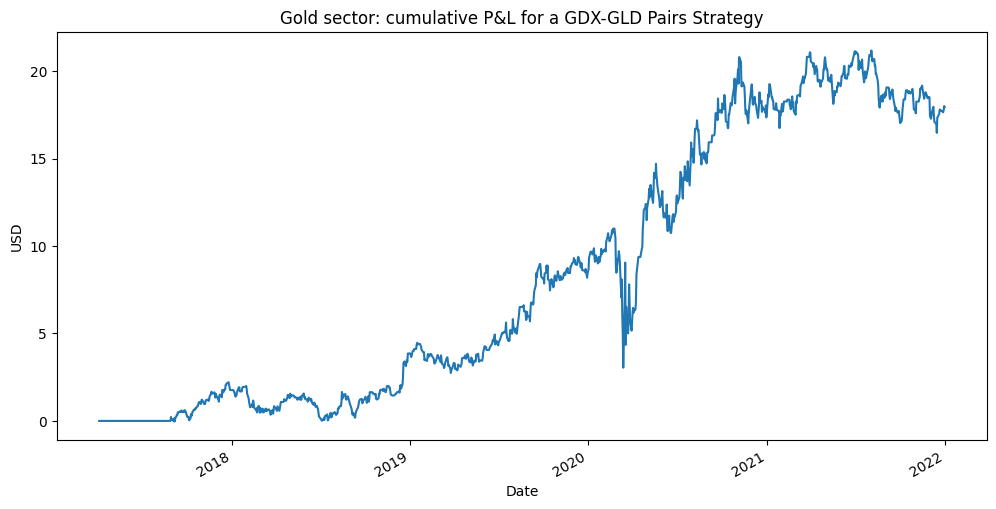

Annualised Sharpe for Gold sector pair strategy ≈ 0.61


In [64]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold_no_switch.shift() * spread_returns
cum_pnl_gold_no_switch = strategy_ret.cumsum()
cum_pnl_gold_no_switch.name = "PnL Gold pair"

# Results
fig, ax = plt.subplots()
cum_pnl_gold_no_switch.plot(ax=ax, title="Gold sector: cumulative P&L for a GDX-GLD Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_gold_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold_no_switch:.2f}")

The annualised Sharpe ratio of the vanilla strategy with updated exit condition is slightly less than that with the previous exit condition ($0.61$ vs $0.69$).

A brief reminder that this was the most effortlessly cointegrated pair among the three considered.

In [65]:
# apply vol switch to trading strategy 
position_gold_with_switch = position_gold_no_switch.where(~switch_high_vol, 0)

position_gold_with_switch.name = "Spread Position"
# position_gold_with_switch

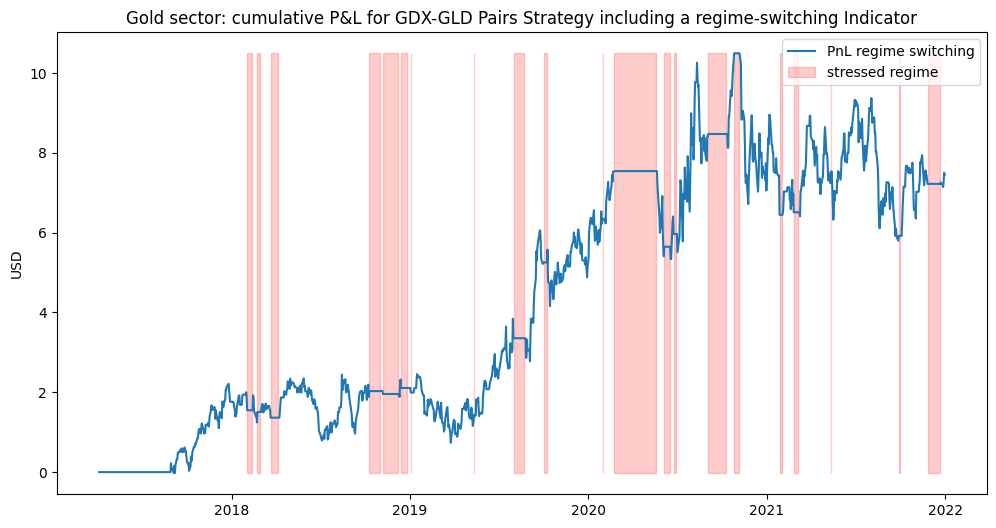

Annualised Sharpe for Gold sector pair strategy ≈ 0.40


In [66]:
# Strategy returns
spread_returns = spread_gold.iloc[roll_window:].diff()
strategy_ret = position_gold_with_switch.shift() * spread_returns
cum_pnl_gold_with_switch = strategy_ret.cumsum()
cum_pnl_gold_with_switch.name = "PnL Gold pair"

min_pnl = cum_pnl_gold_with_switch.min()
max_pnl = cum_pnl_gold_with_switch.max()
# Results
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Gold sector: cumulative P&L for GDX-GLD Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_gold_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Gold sector pair strategy ≈ {annual_sharpe_gold_with_switch:.2f}")

The annualised Sharpe ratio of the regime switching strategy is more than $30 \%$ down with respect to the vanilla strategy.

This is readily explained by the fact that Gold is a refuge asset in times of crisis, and as a result the cointegrated ETFs did not in fact lose much money during the Covid 2020 crisis.
The improved pair strategy, by virtue of stopping to trade during high volatility times, unwittingly foregoes the profits made by this refuge asset in the immediate afterward of such junctures.

This is visible if we superimpose profits from the vanilla and from the regime switching pair strategies:

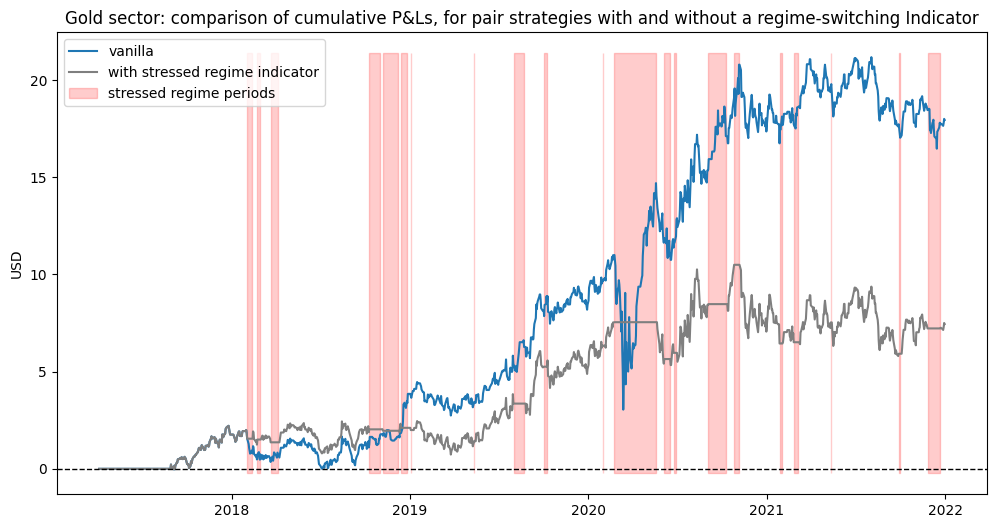

In [67]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_gold_with_switch.min(), cum_pnl_gold_no_switch.min())
max_pnl = max(cum_pnl_gold_with_switch.max(), cum_pnl_gold_no_switch.max())

plt.plot(cum_pnl_gold_no_switch.index, cum_pnl_gold_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Gold sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="upper left")

plt.show()

#### Strategy 3: Technology ETFs

Lastly, the technology ETFs.

In [68]:
# OLS regression and spread
y = prices["IYW"]
X = sm.add_constant(prices["XLK"])
model_tech = sm.OLS(y, X).fit()
alpha_tech, beta_tech = model_tech.params
spread_tech = y - (alpha_tech + beta_tech * prices["XLK"])
spread_tech.name = "Spread"

In [69]:
# baseline strategy
roll_window = 63 # trimestral
zscore_tech = (spread_tech - spread_tech.rolling(roll_window).mean()) / spread_tech.rolling(roll_window).std()
long_entry  = zscore_tech <= -2
short_entry = zscore_tech >=  2
# new: exit position when zscore changes sign (or its abs value is less than tolerance=0.1)
exit_no_switch = np.sign(zscore_tech) != np.sign(zscore_tech.shift())
exit_no_switch = exit_no_switch.where(exit_no_switch, zscore_tech.abs() < 0.1)

position_tech_no_switch = np.where(long_entry,  
    1,
    np.where(short_entry, 
        -1, 
        np.nan
    )
)
position_tech_no_switch = pd.Series(position_tech_no_switch, index=prices.index).ffill().where(~exit_no_switch, 0).iloc[roll_window:]
position_tech_no_switch = position_tech_no_switch.fillna(0)		# fills string of initial na (before first trade) to 0
position_tech_no_switch.name = "Spread Position"
# position_tech

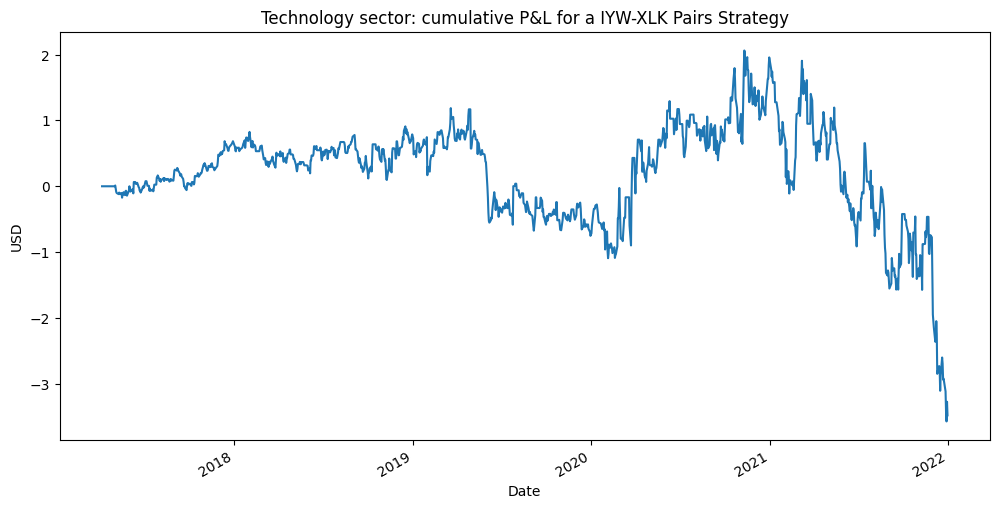

Annualised Sharpe for Technology sector pair strategy ≈ -0.31


In [70]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech_no_switch.shift() * spread_returns
cum_pnl_tech_no_switch = strategy_ret.cumsum()
cum_pnl_tech_no_switch.name = "PnL Technology pair"

# Results
fig, ax = plt.subplots()
cum_pnl_tech_no_switch.plot(ax=ax, title="Technology sector: cumulative P&L for a IYW-XLK Pairs Strategy")
ax.set_ylabel("USD")
plt.show()

annual_sharpe_tech_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech_no_switch:.2f}")

Annualised Sharpe ratio of vanilla pair strategy with new exit condition for these ETFs is magnified $10 \times$ for the worst, from $-0.03$ to $-0.31$.

In [71]:
# apply vol switch to trading strategy 
position_tech_with_switch = position_tech_no_switch.where(~switch_high_vol, 0)

position_tech_with_switch.name = "Spread Position"
# position_tech_with_switch

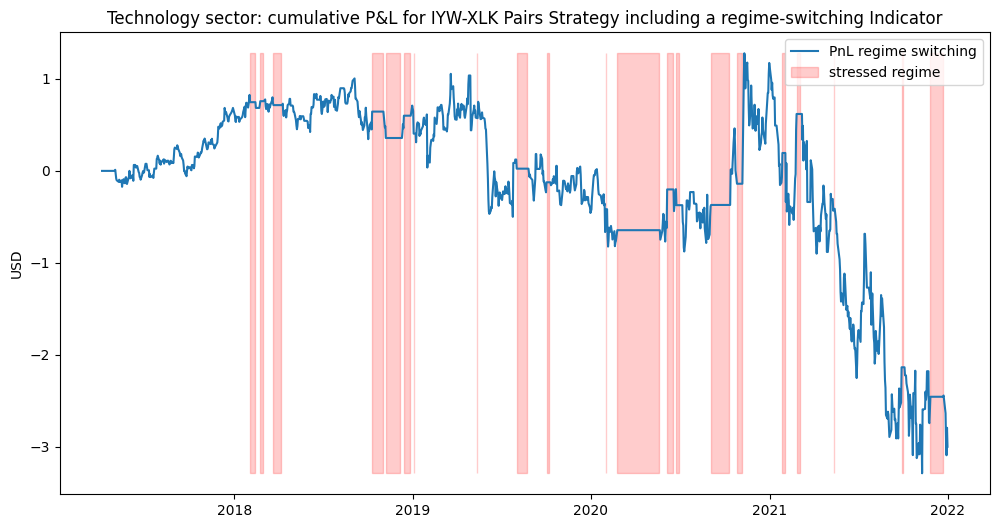

Annualised Sharpe for Technology sector pair strategy ≈ -0.32


In [72]:
# Strategy returns
spread_returns = spread_tech.iloc[roll_window:].diff()
strategy_ret = position_tech_with_switch.shift() * spread_returns
cum_pnl_tech_with_switch = strategy_ret.cumsum()
cum_pnl_tech_with_switch.name = "PnL Technology pair"

min_pnl = cum_pnl_tech_with_switch.min()
max_pnl = cum_pnl_tech_with_switch.max()
# Results
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, label="PnL regime switching")
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime")
plt.ylabel("USD")
plt.title("Technology sector: cumulative P&L for IYW-XLK Pairs Strategy including a regime-switching Indicator")
plt.legend()
plt.show()

annual_sharpe_tech_with_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
print(f"Annualised Sharpe for Technology sector pair strategy ≈ {annual_sharpe_tech_with_switch:.2f}")

Adding the regime-switching indicator to the pair strategy for the technology sector does in fact make little if any difference in terms of annualised Sharpe ratio, and also as seen in the comparison graph below.

This might be explained with the peculiar nature of the Covid 2020 crisis and the lockdowns, which forced people indoors and as a result spurred growth for demand of electronic devices and for internet usage.
This sector actually profited from the Covid 2020 crisis, and the the pair strategy fails to take advantage of this.

However, with respect to the vanilla strategy, the improved regime-switching strategy manages to avoid losses during high-volatility periods after 2020, and as a result the two strategies finish at the same level of profitability (loss, really) at the end of the timeframe considered (January 2022).

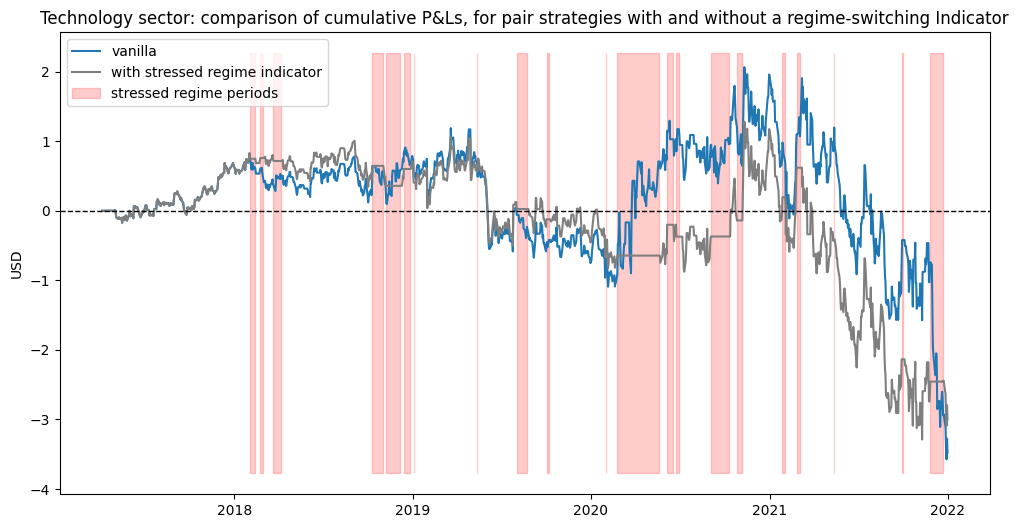

In [73]:
# comparison of switch vs no-switch strategies
min_pnl = min(cum_pnl_tech_with_switch.min(), cum_pnl_tech_no_switch.min())
max_pnl = max(cum_pnl_tech_with_switch.max(), cum_pnl_tech_no_switch.max())

plt.plot(cum_pnl_tech_no_switch.index, cum_pnl_tech_no_switch, color='tab:blue', label="vanilla")
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, color='tab:gray', label="with stressed regime indicator")
plt.fill_between(switch_high_vol.index, min_pnl-0.2, max_pnl+0.2, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="stressed regime periods")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Technology sector: comparison of cumulative P&Ls, for pair strategies with and without a regime-switching Indicator")
plt.legend(loc="upper left")

plt.show()

## Step 3

### Backtest both the vanilla and regime-switching strategy over the period 2017-22. Then include a transaction cost of ten basis points, and calculate performance statistics for both strategies.

In [74]:
pd.set_option('display.precision', 4)

Since we already run backtesting of both strategies for the three pairs of ETFs in Section 2, here we will focus on adding a fixed transaction cost $y = 0.001$ to each trade 

\begin{align}
r_{\text{spread, net}}(t) = & \left[ r_{\text{spread}}(t) - r_{\text{spread}}(t-1) \right] - y \cdot \left| r_{\text{spread}}(t) - r_{\text{spread}}(t-1) \right| = \\
= & \begin{cases}
    0.999 \cdot \Delta r_{\text{spread}} (t) & \text{if } \Delta r_{\text{spread}} (t) > 0\\
	-1.001 \cdot \left| \Delta r_{\text{spread}} (t) \right| & \text{if } \Delta r_{\text{spread}} (t) < 0\\
	0 & \text{if } \Delta r_{\text{spread}} (t) = 0
\end{cases}
\end{align}

where $r_{\text{spread}} (t)$ is the spread of residuals, which also functions as amount of trade, at any instant $t$ in which either trading strategy is activated, and $$\Delta r_{\text{spread}}(t) = r_{\text{spread}}(t) - r_{\text{spread}}(t-1)$$

#### Performance Statistics

We will also calculate a few indicators in order to track the overall performance of the two pair strategies (vanilla and with added regime-switching) with and without transaction fees.

The performance statistics considered are the following:

1. **Cumulative Returns**: the PnL value of the strategy $S$ at the end of the timeframe considered
2. **Annualised Sharpe Ratio**: assuming a risk-free rate of $0 \%$, this is $$\text{SR} = \frac{\mu_S}{\sigma_S} \sqrt{252}$$
3. **Maximum Drawdown(\%)**: this is the maximum (absolute) distance between a through and the highest preceding peak $$\text{MDD} = \min_{t \in (0, T)} \frac{S(t) - \max_{\overline{t} < t} S(\overline{t})}{\max_{\overline{t} < t} S(\overline{t})} \cdot 100$$
4. **Number of Trades**: the total number of trades entered (in both directions)
5. **Time Activity Ratio(\%)**: the number of trades entered (one per day) in proportion to the number of business days available in the selected timeframe 2017-22
6. **Winning Rate (\%)**: the ratio of profitable trades over the total of trades entered.

#### 1. Energy ETFs

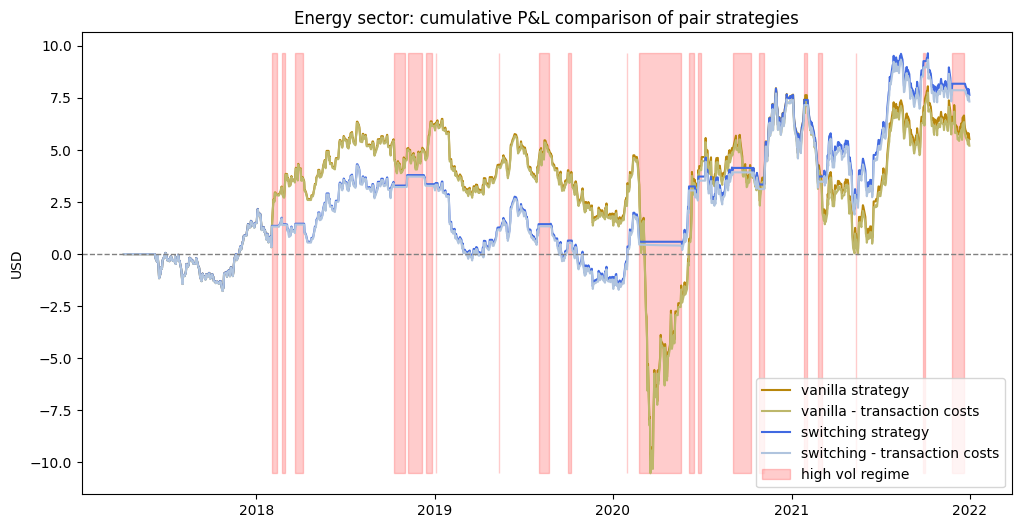

In [75]:
# Strategy returns
shaving = 0.001
spread_returns = spread_energy.iloc[roll_window:].diff()

# original returns
strategy_ret = position_energy_no_switch.shift() * spread_returns
cum_pnl_energy_no_switch = strategy_ret.cumsum().dropna()
cum_pnl_energy_no_switch.name = "PnL Energy pair"
# shaved returns
strategy_ret_shaved = position_energy_no_switch.shift() * spread_returns
strategy_ret_shaved -= shaving * abs(spread_returns)
cum_pnl_energy_no_switch_shaved = strategy_ret_shaved.cumsum().dropna()
cum_pnl_energy_no_switch_shaved.name = "PnL Energy pair"
# original switching returns
strategy_ret_with_switch = position_energy_with_switch.shift() * spread_returns
cum_pnl_energy_with_switch = strategy_ret_with_switch.cumsum().dropna()
cum_pnl_energy_with_switch.name = "PnL Energy pair"
# shaved switching returns
strategy_ret_with_switch_shaved = position_energy_with_switch.shift() * spread_returns
strategy_ret_with_switch_shaved -= shaving * abs(spread_returns)
cum_pnl_energy_with_switch_shaved = strategy_ret_with_switch_shaved.cumsum().dropna()
cum_pnl_energy_with_switch_shaved.name = "PnL Energy pair"

# Results
fig = plt.subplots()
plt.plot(cum_pnl_energy_no_switch.index, cum_pnl_energy_no_switch, color='darkgoldenrod', label="vanilla strategy")
plt.plot(cum_pnl_energy_no_switch_shaved.index, cum_pnl_energy_no_switch_shaved, color='darkkhaki', label="vanilla - transaction costs")
plt.plot(cum_pnl_energy_with_switch.index, cum_pnl_energy_with_switch, color='royalblue', label="switching strategy")
plt.plot(cum_pnl_energy_with_switch_shaved.index, cum_pnl_energy_with_switch_shaved, color='lightsteelblue', label="switching - transaction costs")
plt.axhline(0, ls="--", color="gray", lw=1)
min_pnl = cum_pnl_energy_no_switch_shaved.min()
max_pnl = cum_pnl_energy_with_switch.max()
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="high vol regime")
plt.ylabel("USD")
plt.title("Energy sector: cumulative P&L comparison of pair strategies")
plt.legend(loc="lower right")
plt.show()

In [76]:
annual_sharpe_energy_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
annual_sharpe_energy_no_switch_shaved = (strategy_ret_shaved.mean() / strategy_ret_shaved.std()) * np.sqrt(252)
annual_sharpe_energy_with_switch = (strategy_ret_with_switch.mean() / strategy_ret_with_switch.std()) * np.sqrt(252)
annual_sharpe_energy_with_switch_shaved = (strategy_ret_with_switch_shaved.mean() / strategy_ret_with_switch_shaved.std()) * np.sqrt(252)
# print(f"Annualised Sharpe for Energy sector pair vanilla strategy ≈ {annual_sharpe_energy_no_switch:.2f}")
# print(f"Annualised Sharpe for Energy sector pair vanilla strategy with transaction costs ≈ {annual_sharpe_energy_no_switch_shaved:.2f}")
# print(f"Annualised Sharpe for Energy sector pair regime switching strategy ≈ {annual_sharpe_energy_with_switch:.2f}")
# print(f"Annualised Sharpe for Energy sector pair regime switching strategy with transaction costs ≈ {annual_sharpe_energy_with_switch_shaved:.2f}")

As it could be expected, transaction costs shave a little profit away from both pair strategies.

In [77]:
# drawdown function
def computeDrawdown(series):
	local_min = series[0]
	local_max = series[0]
	min_drawdown = 0
	for trade in series:
		local_min = min(local_min, trade)
		local_max = max(local_max, trade)
		if local_max == trade:
			local_min = trade
		# taking the division only at the end avoids
		# amplifying drawdowns at near zero profits/losses
		drawdown = (local_min - local_max) #/ local_max
		if local_max == 0:
			drawdown = 0
		min_drawdown = min(min_drawdown, drawdown)
		if min_drawdown == drawdown:
			max_at_drawdown = local_max
		#print(min_drawdown, local_min, local_max, trade)
	
	return min_drawdown/max_at_drawdown

In [78]:
def numberOfTrades(pandas_series):
    return np.count_nonzero(pandas_series)

In [79]:
def winRate(series, regime_switch_bool):
    total_trades= 0
    if regime_switch_bool:
        total_trades = numberOfTrades(position_energy_with_switch)
    else:
        total_trades = numberOfTrades(position_energy_no_switch)
        
    days_winning = len( np.extract(series > series.shift(), series) )

    return days_winning / total_trades

Below, a summary table of the six performance indicators considered, for both pair strategies (vanilla and with regime-switching indicator), with and without transaction costs, hence a total of four cases.

Following that, a graphic representation of the performance indicators 

- first, for just the two pair strategies as impacted by transaction costs
- then, for all four strategy variants, but only covering three performance indicators, as the other three show no difference between strategies with or without transaction costs.

In [80]:
strategies_shaved = ["vanilla", "switching"]
strategies = ["vanilla", "vanilla - t. costs", "switching", "switching - t. costs"]

# compare cumulative returns
final_pnl_shaved = np.array([cum_pnl_energy_no_switch_shaved[-1], cum_pnl_energy_with_switch_shaved[-1]])
final_pnl = np.array([cum_pnl_energy_no_switch[-1], cum_pnl_energy_no_switch_shaved[-1], cum_pnl_energy_with_switch[-1], cum_pnl_energy_with_switch_shaved[-1]])

# compare annualised Sharpe ratios
sharpe_shaved = np.array([annual_sharpe_energy_no_switch_shaved, annual_sharpe_energy_with_switch_shaved])
sharpe = np.array([annual_sharpe_energy_no_switch, annual_sharpe_energy_no_switch_shaved, annual_sharpe_energy_with_switch, annual_sharpe_energy_with_switch_shaved])

# maximum drawdown
drawdown_shaved= np.array([
    computeDrawdown(cum_pnl_energy_no_switch_shaved),
    computeDrawdown(cum_pnl_energy_with_switch_shaved)
])
drawdown = np.array([
    computeDrawdown(cum_pnl_energy_no_switch),
    computeDrawdown(cum_pnl_energy_no_switch_shaved),
    computeDrawdown(cum_pnl_energy_with_switch),
    computeDrawdown(cum_pnl_energy_with_switch_shaved)
])

# number of trades
trades_shaved = np.array([
    numberOfTrades(position_energy_no_switch),
    numberOfTrades(position_energy_with_switch)
])
trades = np.array([
    numberOfTrades(position_energy_no_switch),
    numberOfTrades(position_energy_no_switch),
    numberOfTrades(position_energy_with_switch),
    numberOfTrades(position_energy_with_switch)
])

# % time active
time_active_shaved = trades_shaved / position_energy_no_switch.shape[0]
time_active = trades / position_energy_no_switch.shape[0]

# % winning trades
winning_rate_shaved = np.array([
    winRate(cum_pnl_energy_no_switch, False),
    winRate(cum_pnl_energy_with_switch, True)
])
winning_rate = np.array([
    winRate(cum_pnl_energy_no_switch, False),
    winRate(cum_pnl_energy_no_switch_shaved, False),
    winRate(cum_pnl_energy_with_switch, True),
    winRate(cum_pnl_energy_with_switch_shaved, True)
])

perf_stats_names = ["Cumulative Return", "Annualised Sharpe Ratio", "% Maximum Drawdown", "Number of Trades", "% Time Active", "% Winning Rate"]

performance_energy = pd.DataFrame(data=np.stack((final_pnl, sharpe, drawdown * 100, trades, time_active * 100, winning_rate * 100), axis=1), index=strategies, columns=perf_stats_names)
performance_energy.index.name = "Energy Strategies"
performance_energy

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Energy Strategies,,,,,,
vanilla,5.5223,0.1914,-259.7611,1054.0,88.1271,50.0949
vanilla - t. costs,5.2057,0.1805,-264.1618,1054.0,88.1271,50.0949
switching,7.6441,0.3873,-136.9204,837.0,69.9833,50.5376
switching - t. costs,7.3275,0.3713,-140.3710,837.0,69.9833,50.5376


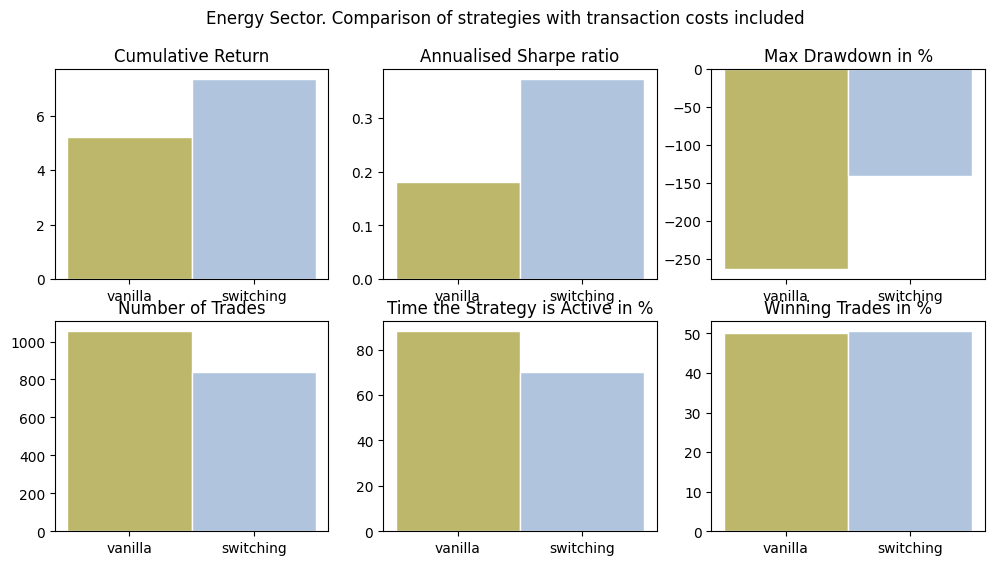

In [81]:
fig, ax = plt.subplots(2, 3)

ax[0,0].bar(strategies_shaved, final_pnl_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,0].set_title("Cumulative Return")
ax[0,1].bar(strategies_shaved, sharpe_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[0,1].set_title("Annualised Sharpe ratio")
ax[0,2].bar(strategies_shaved, drawdown_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,2].set_title("Max Drawdown in %")
ax[1,0].bar(strategies_shaved, trades_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,0].set_title("Number of Trades")
ax[1,1].bar(strategies_shaved, time_active_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,1].set_title("Time the Strategy is Active in %")
ax[1,2].bar(strategies_shaved, winning_rate_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Energy Sector. Comparison of strategies with transaction costs included")

plt.tight_layout
plt.show()

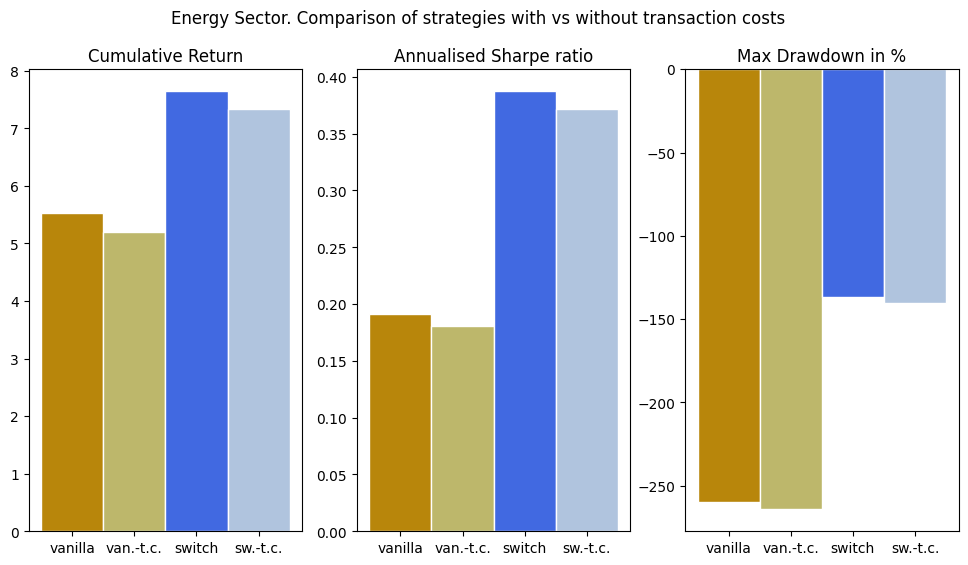

In [82]:
strategies_brief = ["vanilla", "van.-t.c.", "switch", "sw.-t.c."]
fig, ax = plt.subplots(1, 3)

ax[0].bar(strategies_brief, final_pnl, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0].set_title("Cumulative Return")
ax[1].bar(strategies_brief, sharpe, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[1].set_title("Annualised Sharpe ratio")
ax[2].bar(strategies_brief, drawdown * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[2].set_title("Max Drawdown in %")
# ax[1,0].bar(strategies, trades, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,0].set_title("Number of Trades")
# ax[1,1].bar(strategies, time_active * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,1].set_title("Time the Strategy is Active in %")
# ax[1,2].bar(strategies, winning_rate * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Energy Sector. Comparison of strategies with vs without transaction costs")

plt.tight_layout
plt.show()

#### 2. Gold ETFs

The backtest and the performance analysis here is the same as done for the Energy pair strategy.

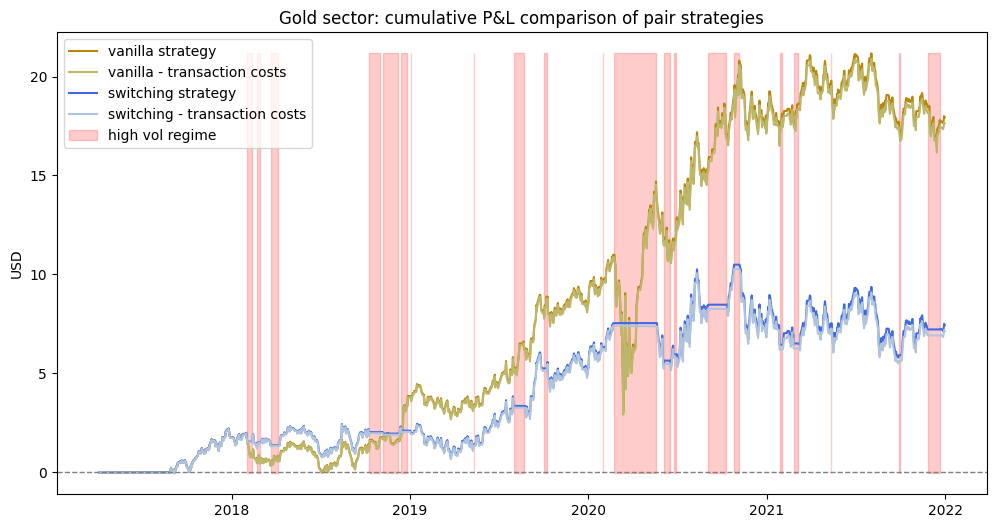

In [83]:
# Strategy returns
shaving = 0.001
spread_returns = spread_gold.iloc[roll_window:].diff()

# original returns
strategy_ret = position_gold_no_switch.shift() * spread_returns
cum_pnl_gold_no_switch = strategy_ret.cumsum().dropna()
cum_pnl_gold_no_switch.name = "PnL Gold pair"
# shaved returns
strategy_ret_shaved = position_gold_no_switch.shift() * spread_returns
strategy_ret_shaved -= shaving * abs(spread_returns)
cum_pnl_gold_no_switch_shaved = strategy_ret_shaved.cumsum().dropna()
cum_pnl_gold_no_switch_shaved.name = "PnL Gold pair"
# original switching returns
strategy_ret_with_switch = position_gold_with_switch.shift() * spread_returns
cum_pnl_gold_with_switch = strategy_ret_with_switch.cumsum().dropna()
cum_pnl_gold_with_switch.name = "PnL Gold pair"
# shaved switching returns
strategy_ret_with_switch_shaved = position_gold_with_switch.shift() * spread_returns
strategy_ret_with_switch_shaved -= shaving * abs(spread_returns)
cum_pnl_gold_with_switch_shaved = strategy_ret_with_switch_shaved.cumsum().dropna()
cum_pnl_gold_with_switch_shaved.name = "PnL Gold pair"

# Results
fig = plt.subplots()
plt.plot(cum_pnl_gold_no_switch.index, cum_pnl_gold_no_switch, color='darkgoldenrod', label="vanilla strategy")
plt.plot(cum_pnl_gold_no_switch_shaved.index, cum_pnl_gold_no_switch_shaved, color='darkkhaki', label="vanilla - transaction costs")
plt.plot(cum_pnl_gold_with_switch.index, cum_pnl_gold_with_switch, color='royalblue', label="switching strategy")
plt.plot(cum_pnl_gold_with_switch_shaved.index, cum_pnl_gold_with_switch_shaved, color='lightsteelblue', label="switching - transaction costs")
plt.axhline(0, ls="--", color="gray", lw=1)
min_pnl = cum_pnl_gold_no_switch_shaved.min()
max_pnl = cum_pnl_gold_no_switch.max()
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="high vol regime")
plt.ylabel("USD")
plt.title("Gold sector: cumulative P&L comparison of pair strategies")
plt.legend(loc="upper left")
plt.show()

In [84]:
annual_sharpe_gold_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
annual_sharpe_gold_no_switch_shaved = (strategy_ret_shaved.mean() / strategy_ret_shaved.std()) * np.sqrt(252)
annual_sharpe_gold_with_switch = (strategy_ret_with_switch.mean() / strategy_ret_with_switch.std()) * np.sqrt(252)
annual_sharpe_gold_with_switch_shaved = (strategy_ret_with_switch_shaved.mean() / strategy_ret_with_switch_shaved.std()) * np.sqrt(252)

In [85]:
strategies_shaved = ["vanilla", "switching"]
strategies = ["vanilla", "vanilla - t. costs", "switching", "switching - t. costs"]

# compare cumulative returns
final_pnl_shaved = np.array([cum_pnl_gold_no_switch_shaved[-1], cum_pnl_gold_with_switch_shaved[-1]])
final_pnl = np.array([cum_pnl_gold_no_switch[-1], cum_pnl_gold_no_switch_shaved[-1], cum_pnl_gold_with_switch[-1], cum_pnl_gold_with_switch_shaved[-1]])

# compare annualised Sharpe ratios
sharpe_shaved = np.array([annual_sharpe_gold_no_switch_shaved, annual_sharpe_gold_with_switch_shaved])
sharpe = np.array([annual_sharpe_gold_no_switch, annual_sharpe_gold_no_switch_shaved, annual_sharpe_gold_with_switch, annual_sharpe_gold_with_switch_shaved])

# maximum drawdown
drawdown_shaved= np.array([
    computeDrawdown(cum_pnl_gold_no_switch_shaved),
    computeDrawdown(cum_pnl_gold_with_switch_shaved)
])
drawdown = np.array([
    computeDrawdown(cum_pnl_gold_no_switch),
    computeDrawdown(cum_pnl_gold_no_switch_shaved),
    computeDrawdown(cum_pnl_gold_with_switch),
    computeDrawdown(cum_pnl_gold_with_switch_shaved)
])

# number of trades
trades_shaved = np.array([
    numberOfTrades(position_gold_no_switch),
    numberOfTrades(position_gold_with_switch)
])
trades = np.array([
    numberOfTrades(position_gold_no_switch),
    numberOfTrades(position_gold_no_switch),
    numberOfTrades(position_gold_with_switch),
    numberOfTrades(position_gold_with_switch)
])

# % time active
time_active_shaved = trades_shaved / position_gold_no_switch.shape[0]
time_active = trades / position_gold_no_switch.shape[0]

# % winning trades
winning_rate_shaved = np.array([
    winRate(cum_pnl_gold_no_switch, False),
    winRate(cum_pnl_gold_with_switch, True)
])
winning_rate = np.array([
    winRate(cum_pnl_gold_no_switch, False),
    winRate(cum_pnl_gold_no_switch_shaved, False),
    winRate(cum_pnl_gold_with_switch, True),
    winRate(cum_pnl_gold_with_switch_shaved, True)
])

perf_stats_names = ["Cumulative Return", "Annualised Sharpe Ratio", "% Maximum Drawdown", "Number of Trades", "% Time Active", "% Winning Rate"]

performance_gold = pd.DataFrame(data=np.stack((final_pnl, sharpe, drawdown * 100, trades, time_active * 100, winning_rate * 100), axis=1), index=strategies, columns=perf_stats_names)
performance_gold.index.name = "Gold Strategies"
performance_gold

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Gold Strategies,,,,,,
vanilla,17.9387,0.6078,-72.3196,985.0,82.3579,47.7230
vanilla - t. costs,17.6332,0.5975,-73.2130,985.0,82.3579,47.7230
switching,7.4407,0.3993,-44.7317,779.0,65.1338,46.8339
switching - t. costs,7.1352,0.3829,-46.3758,779.0,65.1338,46.8339


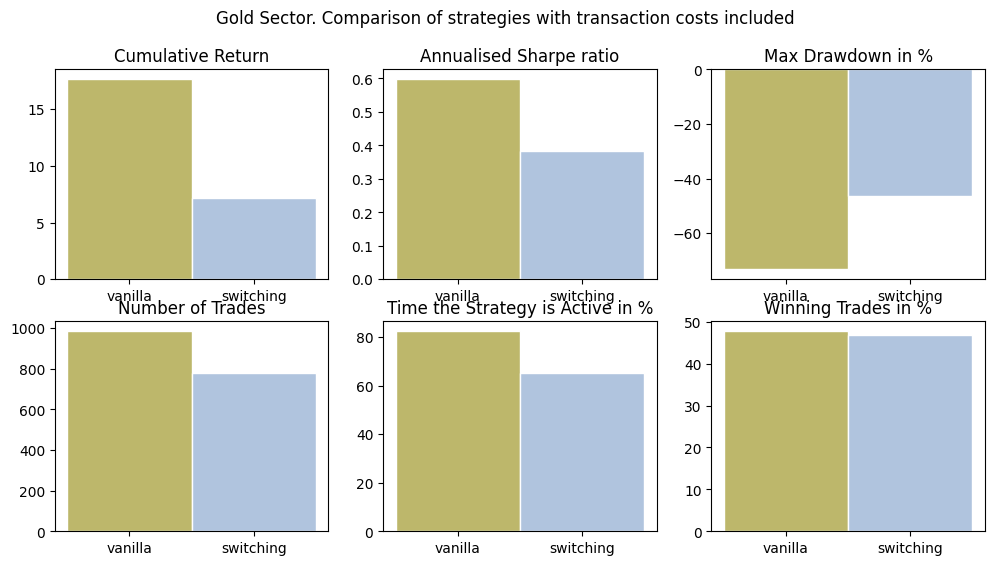

In [86]:
fig, ax = plt.subplots(2, 3)

ax[0,0].bar(strategies_shaved, final_pnl_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,0].set_title("Cumulative Return")
ax[0,1].bar(strategies_shaved, sharpe_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,1].set_title("Annualised Sharpe ratio")
ax[0,2].bar(strategies_shaved, drawdown_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,2].set_title("Max Drawdown in %")
ax[1,0].bar(strategies_shaved, trades_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,0].set_title("Number of Trades")
ax[1,1].bar(strategies_shaved, time_active_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,1].set_title("Time the Strategy is Active in %")
ax[1,2].bar(strategies_shaved, winning_rate_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Gold Sector. Comparison of strategies with transaction costs included")

plt.tight_layout
plt.show()

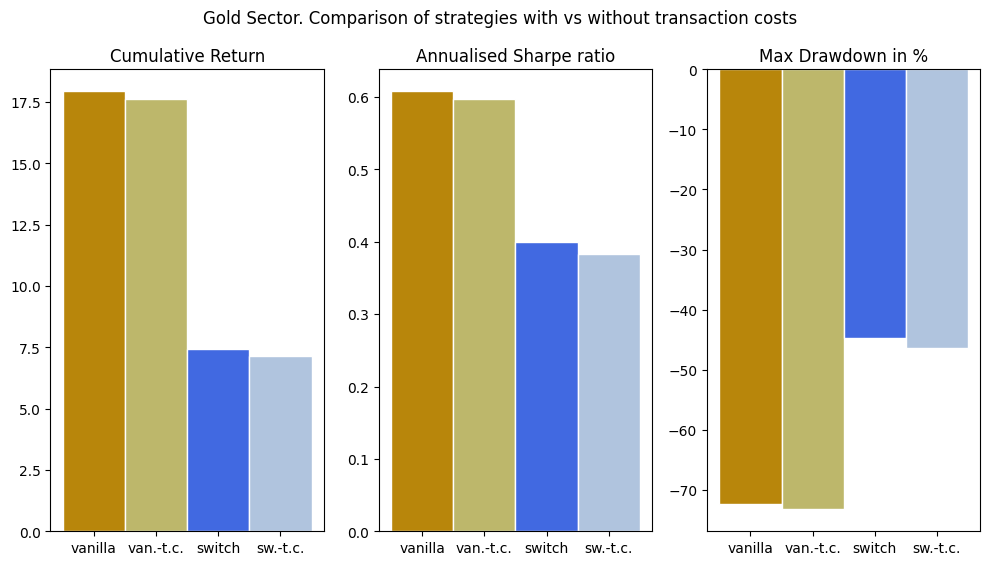

In [87]:
strategies_brief = ["vanilla", "van.-t.c.", "switch", "sw.-t.c."]
fig, ax = plt.subplots(1, 3)

ax[0].bar(strategies_brief, final_pnl, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0].set_title("Cumulative Return")
ax[1].bar(strategies_brief, sharpe, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1) 
ax[1].set_title("Annualised Sharpe ratio")
ax[2].bar(strategies_brief, drawdown * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[2].set_title("Max Drawdown in %")

fig.suptitle("Gold Sector. Comparison of strategies with vs without transaction costs")

plt.tight_layout
plt.show()

#### 3. Technology ETFs

The backtest and the performance analysis here is the same as done for the Energy pair strategy.

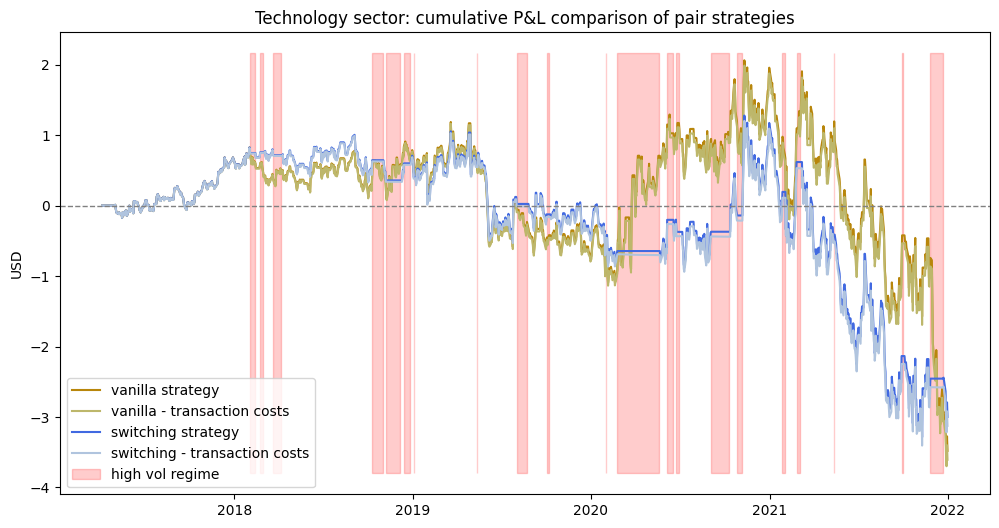

In [88]:
# Strategy returns
shaving = 0.001
spread_returns = spread_tech.iloc[roll_window:].diff()

# original returns
strategy_ret = position_tech_no_switch.shift() * spread_returns
cum_pnl_tech_no_switch = strategy_ret.cumsum().dropna()
cum_pnl_tech_no_switch.name = "PnL Technology pair"
# shaved returns
strategy_ret_shaved = position_tech_no_switch.shift() * spread_returns
strategy_ret_shaved -= shaving * abs(spread_returns)
cum_pnl_tech_no_switch_shaved = strategy_ret_shaved.cumsum().dropna()
cum_pnl_tech_no_switch_shaved.name = "PnL Technology pair"
# original switching returns
strategy_ret_with_switch = position_tech_with_switch.shift() * spread_returns
cum_pnl_tech_with_switch = strategy_ret_with_switch.cumsum().dropna()
cum_pnl_tech_with_switch.name = "PnL Technology pair"
# shaved switching returns
strategy_ret_with_switch_shaved = position_tech_with_switch.shift() * spread_returns
strategy_ret_with_switch_shaved -= shaving * abs(spread_returns)
cum_pnl_tech_with_switch_shaved = strategy_ret_with_switch_shaved.cumsum().dropna()
cum_pnl_tech_with_switch_shaved.name = "PnL Technology pair"

# Results
fig = plt.subplots()
plt.plot(cum_pnl_tech_no_switch.index, cum_pnl_tech_no_switch, color='darkgoldenrod', label="vanilla strategy")
plt.plot(cum_pnl_tech_no_switch_shaved.index, cum_pnl_tech_no_switch_shaved, color='darkkhaki', label="vanilla - transaction costs")
plt.plot(cum_pnl_tech_with_switch.index, cum_pnl_tech_with_switch, color='royalblue', label="switching strategy")
plt.plot(cum_pnl_tech_with_switch_shaved.index, cum_pnl_tech_with_switch_shaved, color='lightsteelblue', label="switching - transaction costs")
plt.axhline(0, ls="--", color="gray", lw=1)
min_pnl = cum_pnl_tech_no_switch_shaved.min() - 0.1
max_pnl = cum_pnl_tech_no_switch.max() + 0.1
plt.fill_between(switch_high_vol.index, min_pnl, max_pnl, where=switch_high_vol.values == 1, color="r", alpha=0.2, label="high vol regime")
plt.ylabel("USD")
plt.title("Technology sector: cumulative P&L comparison of pair strategies")
plt.legend(loc="lower left")
plt.show()

In [89]:
annual_sharpe_tech_no_switch = (strategy_ret.mean() / strategy_ret.std()) * np.sqrt(252)
annual_sharpe_tech_no_switch_shaved = (strategy_ret_shaved.mean() / strategy_ret_shaved.std()) * np.sqrt(252)
annual_sharpe_tech_with_switch = (strategy_ret_with_switch.mean() / strategy_ret_with_switch.std()) * np.sqrt(252)
annual_sharpe_tech_with_switch_shaved = (strategy_ret_with_switch_shaved.mean() / strategy_ret_with_switch_shaved.std()) * np.sqrt(252)

In [90]:
strategies_shaved = ["vanilla", "switching"]
strategies = ["vanilla", "vanilla - t. costs", "switching", "switching - t. costs"]

# compare cumulative returns
final_pnl_shaved = np.array([cum_pnl_tech_no_switch_shaved[-1], cum_pnl_tech_with_switch_shaved[-1]])
final_pnl = np.array([cum_pnl_tech_no_switch[-1], cum_pnl_tech_no_switch_shaved[-1], cum_pnl_tech_with_switch[-1], cum_pnl_tech_with_switch_shaved[-1]])

# compare annualised Sharpe ratios
sharpe_shaved = np.array([annual_sharpe_tech_no_switch_shaved, annual_sharpe_tech_with_switch_shaved])
sharpe = np.array([annual_sharpe_tech_no_switch, annual_sharpe_tech_no_switch_shaved, annual_sharpe_tech_with_switch, annual_sharpe_tech_with_switch_shaved])

# maximum drawdown
drawdown_shaved= np.array([
    computeDrawdown(cum_pnl_tech_no_switch_shaved),
    computeDrawdown(cum_pnl_tech_with_switch_shaved)
])
drawdown = np.array([
    computeDrawdown(cum_pnl_tech_no_switch),
    computeDrawdown(cum_pnl_tech_no_switch_shaved),
    computeDrawdown(cum_pnl_tech_with_switch),
    computeDrawdown(cum_pnl_tech_with_switch_shaved)
])

# number of trades
trades_shaved = np.array([
    numberOfTrades(position_tech_no_switch),
    numberOfTrades(position_tech_with_switch)
])
trades = np.array([
    numberOfTrades(position_tech_no_switch),
    numberOfTrades(position_tech_no_switch),
    numberOfTrades(position_tech_with_switch),
    numberOfTrades(position_tech_with_switch)
])

# % time active
time_active_shaved = trades_shaved / position_tech_no_switch.shape[0]
time_active = trades / position_tech_no_switch.shape[0]

# % winning trades
winning_rate_shaved = np.array([
    winRate(cum_pnl_tech_no_switch, False),
    winRate(cum_pnl_tech_with_switch, True)
])
winning_rate = np.array([
    winRate(cum_pnl_tech_no_switch, False),
    winRate(cum_pnl_tech_no_switch_shaved, False),
    winRate(cum_pnl_tech_with_switch, True),
    winRate(cum_pnl_tech_with_switch_shaved, True)
])

perf_stats_names = ["Cumulative Return", "Annualised Sharpe Ratio", "% Maximum Drawdown", "Number of Trades", "% Time Active", "% Winning Rate"]

performance_tech = pd.DataFrame(data=np.stack((final_pnl, sharpe, drawdown * 100, trades, time_active * 100, winning_rate * 100), axis=1), index=strategies, columns=perf_stats_names)
performance_tech.index.name = "Tech Strategies"
performance_tech

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Tech Strategies,,,,,,
vanilla,-3.4812,-0.3094,-273.2159,1034.0,86.4548,47.9127
vanilla - t. costs,-3.6079,-0.3207,-286.0967,1034.0,86.4548,47.9127
switching,-2.9997,-0.3172,-357.1123,845.0,70.6522,49.5818
switching - t. costs,-3.1263,-0.3306,-382.9737,845.0,70.6522,49.5818


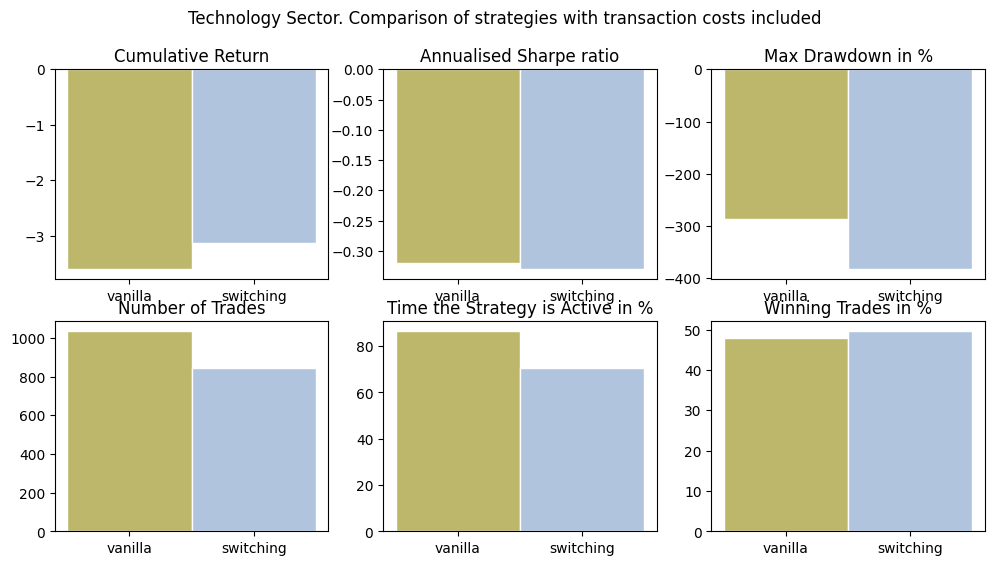

In [91]:
fig, ax = plt.subplots(2, 3)

ax[0,0].bar(strategies_shaved, final_pnl_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,0].set_title("Cumulative Return")
ax[0,1].bar(strategies_shaved, sharpe_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[0,1].set_title("Annualised Sharpe ratio")
ax[0,2].bar(strategies_shaved, drawdown_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0,2].set_title("Max Drawdown in %")
ax[1,0].bar(strategies_shaved, trades_shaved, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,0].set_title("Number of Trades")
ax[1,1].bar(strategies_shaved, time_active_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,1].set_title("Time the Strategy is Active in %")
ax[1,2].bar(strategies_shaved, winning_rate_shaved * 100, width=1, color=["darkkhaki", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Technology Sector. Comparison of strategies with transaction costs included")

plt.tight_layout
plt.show()

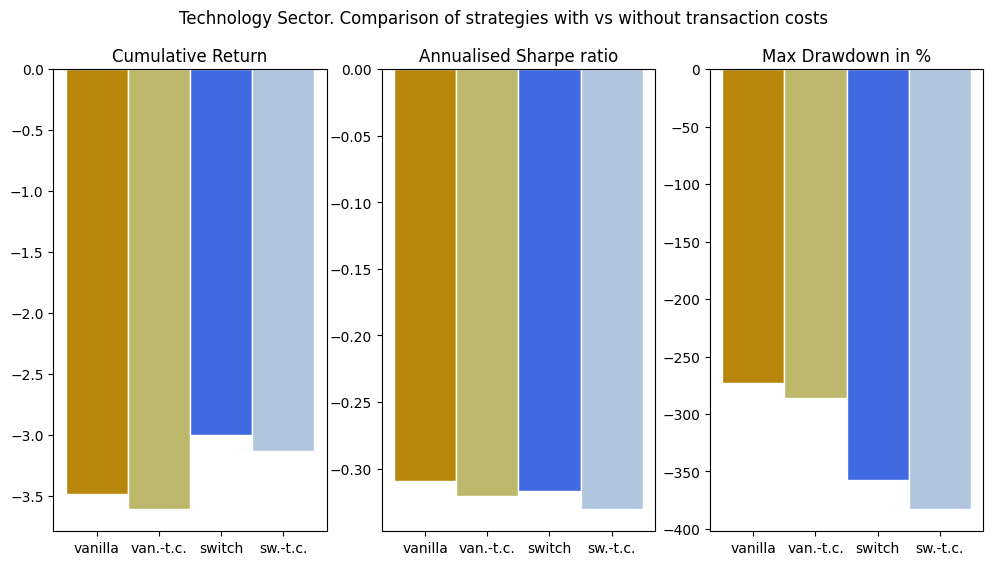

In [92]:
strategies_brief = ["vanilla", "van.-t.c.", "switch", "sw.-t.c."]
fig, ax = plt.subplots(1, 3)

ax[0].bar(strategies_brief, final_pnl, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[0].set_title("Cumulative Return")
ax[1].bar(strategies_brief, sharpe, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[1].set_title("Annualised Sharpe ratio")
ax[2].bar(strategies_brief, drawdown * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
ax[2].set_title("Max Drawdown in %")
# ax[1,0].bar(strategies, trades, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,0].set_title("Number of Trades")
# ax[1,1].bar(strategies, time_active * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,1].set_title("Time the Strategy is Active in %")
# ax[1,2].bar(strategies, winning_rate * 100, width=1, color=["darkgoldenrod", "darkkhaki", "royalblue", "lightsteelblue"], edgecolor="white", linewidth=1)
# ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Technology Sector. Comparison of strategies with vs without transaction costs")

plt.tight_layout
plt.show()

## Step 4

### Interpretation of Results and Critical Analysis

We start this section by briefly summarising performance results from Step 3, for the pair strategies across all three sectors.

Then, we also add a cross comparison across the three sectors (energy, gold, technology) for pair strategies with both regime-switching indicator and transaction fees included.

In [93]:
performance_energy

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Energy Strategies,,,,,,
vanilla,5.5223,0.1914,-259.7611,1054.0,88.1271,50.0949
vanilla - t. costs,5.2057,0.1805,-264.1618,1054.0,88.1271,50.0949
switching,7.6441,0.3873,-136.9204,837.0,69.9833,50.5376
switching - t. costs,7.3275,0.3713,-140.3710,837.0,69.9833,50.5376


In [94]:
performance_gold

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Gold Strategies,,,,,,
vanilla,17.9387,0.6078,-72.3196,985.0,82.3579,47.7230
vanilla - t. costs,17.6332,0.5975,-73.2130,985.0,82.3579,47.7230
switching,7.4407,0.3993,-44.7317,779.0,65.1338,46.8339
switching - t. costs,7.1352,0.3829,-46.3758,779.0,65.1338,46.8339


In [95]:
performance_tech

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
Tech Strategies,,,,,,
vanilla,-3.4812,-0.3094,-273.2159,1034.0,86.4548,47.9127
vanilla - t. costs,-3.6079,-0.3207,-286.0967,1034.0,86.4548,47.9127
switching,-2.9997,-0.3172,-357.1123,845.0,70.6522,49.5818
switching - t. costs,-3.1263,-0.3306,-382.9737,845.0,70.6522,49.5818


In [96]:
# cross-sector comparison of switching strategies with transaction costs included
cp_index = ["Energy", "Gold", "Technology"]
cross_performance = pd.DataFrame(data=np.stack((performance_energy.loc["switching - t. costs"], performance_gold.loc["switching - t. costs"], performance_tech.loc["switching - t. costs"]), axis=0), index=cp_index, columns=perf_stats_names)
cross_performance.index.name = "switch + fees"
cross_performance

,Cumulative Return,Annualised Sharpe Ratio,% Maximum Drawdown,Number of Trades,% Time Active,% Winning Rate
switch + fees,,,,,,
Energy,7.3275,0.3713,-140.3710,837.0,69.9833,50.5376
Gold,7.1352,0.3829,-46.3758,779.0,65.1338,46.8339
Technology,-3.1263,-0.3306,-382.9737,845.0,70.6522,49.5818


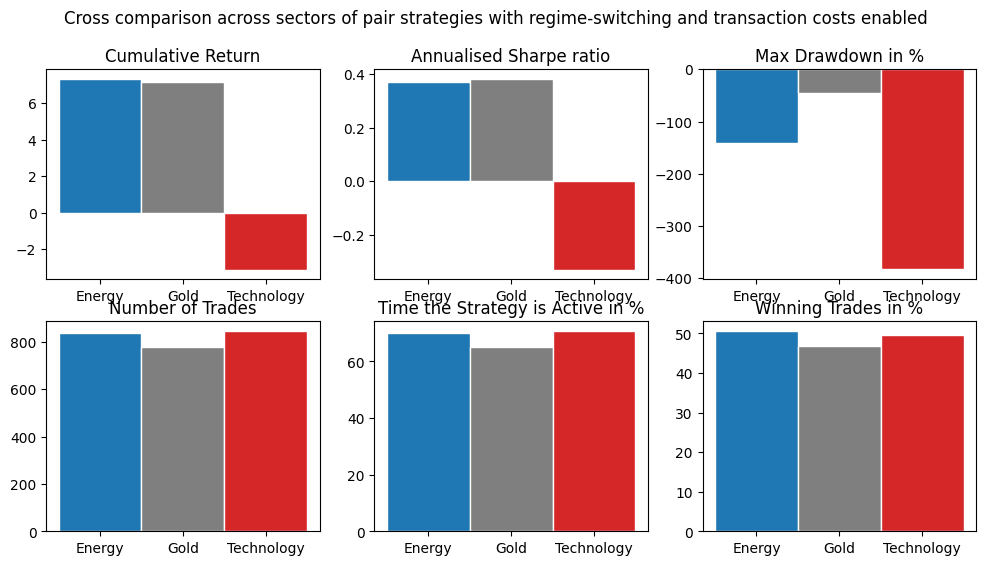

In [97]:
fig, ax = plt.subplots(2, 3)

ax[0,0].bar(cross_performance.index, cross_performance["Cumulative Return"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[0,0].set_title("Cumulative Return")
ax[0,1].bar(cross_performance.index, cross_performance["Annualised Sharpe Ratio"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1) # color=["tab:blue", "tab:gray"], edgecolor="white", linewidth=0.7)
ax[0,1].set_title("Annualised Sharpe ratio")
ax[0,2].bar(cross_performance.index, cross_performance["% Maximum Drawdown"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[0,2].set_title("Max Drawdown in %")
ax[1,0].bar(cross_performance.index, cross_performance["Number of Trades"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[1,0].set_title("Number of Trades")
ax[1,1].bar(cross_performance.index, cross_performance["% Time Active"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[1,1].set_title("Time the Strategy is Active in %")
ax[1,2].bar(cross_performance.index, cross_performance["% Winning Rate"], width=1, color=["tab:blue", "tab:gray", "tab:red"], edgecolor="white", linewidth=1)
ax[1,2].set_title("Winning Trades in %")
fig.suptitle("Cross comparison across sectors of pair strategies with regime-switching and transaction costs enabled")

plt.tight_layout
plt.show()

#### Did the regime-filtering hypothesis hold, with the filtered strategy achieving better performance even with lower returns?

- **Energy sector**: this is the pair strategy which benefitted the most from adding the regime-switching indicator based on high-volatility of the SPY.
Final returns increase from $5.21$ vanilla to $7.33$ after adding the regime-switching indicator. 
Annualised Sharpe Ratio more than doubles going from $0.18$ vanilla to $0.37$ with regime-switch on.
Maximum Drawdown also drops by nearly a half, going from $-264 \%$ vanilla to $-140.4 \%$ with regime-switch on.
Notice here we are comparing numbers from the transaction fees-enabled versions of the pair strategy.
The remaining performance measures reveal a beneficial decrease by about $20 \%$ of number of trades involved and of active days for the strategy in the business calendar, when regime-switching indicator is turned on.
The percentage of winning trades is a shaving better for the regime-switching enable version of the strategy, however nothing of substance, with both the enhanced version and the vanilla strategy hovering around the $50 \%$-success-trades mark.

- **Gold sector**: we recall from results in Section 1.b, that this was the best co-integrated pair of ETFs amongst the three considered.
As a consequence, this pair strategy did not receive any benefit from adding a regime-switching volatility indicator.
In fact, the vanilla version outperforms the regime-switch enabled one in terms of cumulative return (a whopping $17.63$ against $7.14$), of annualised Sharpe ratio ($0.6$ against $0.38$) while being expectedly worse in terms of maximum drawdown ($-73.2 \%$ against $-46.38 \%$), as the regime-switching strategy will obviously assume a more conservative outlook.
This last effect is also reflected in a lower number of trades ($985$ against $779$) and time activity ($82.36 \%$ against $65.13 \%$) for the regime-switching version of the pair strategy. Winning trades are a tad better for the vanilla strategy ($47.72 \%$ against $46.83 \%$).
Adding the transaction fees slightly worsens returns, Sharpe ratio and maximum drawdown, as expected.

- **Technology sector**: this is the pair strategy that performs the worst out of the three, because of the countercyclical nature this economic sector showed with respect to the Covid 2020 crisis. 
That is, the co-integration of the two ETFs considered in this strategy benefitted from the crisis, but was hurt by the recovery immediately afterward.
Final PnL closes in red for both vanilla ($-3.6$) and regime-switching ($-3.13$) strategies, with the enhanced strategy faring a bit better.
Negative values for the annualised Sharpe ratio ($-0.32$ vanilla against $-0.33$ regime-switching) and for the maximum drawdown ($-286 \%$ vanilla against $-383 \%$ regime-switching) show that the regime-switching strategy worsens performance statistics that were already failing for the vanilla strategy.
Number of trades and time activity both predictably favour the regime-switching variant of the pair strategy. Also, the regime-switching approach outperforms slightly the vanilla strategy in the percentage of winning trades ($47.91 \%$ vanilla against $49.58 \%$ regime-switching).
All performance metrics are worsened by simulating a transaction fee to the trades.

- **Cross comparison**: the most evident aspect standing out when considering the performance of the pair strategy across the three economic sectors considered, is that the Technology pair performs far worse than the other two sectors in terms of nearly every metric, lying firmly into negative territory with regards to the cumulative return and the Sharpe ratio, while it shows a record maximum drawdown, nearly $3 \times$ worse than the second worse strategy.
On their own, the Energy and Gold pair strategies can be compared (a) over the performance of their regime-switching versions one against the other, and (b) on how the addition of the regime-switching indicator benefitted one strategy or the other.
In terms of (a) absolute performance, cumulative PnL sees the Energy regime-switching enhanced strategy finishing up at a slightly better position ($7.33$) than its Gold counterpart ($7.14$).
Annualised Sharpe ratio ($0,37$ Energy vs $0.38$ Gold) and most of all maximum drawdown ($-140.38 \%$ Energy vs $-46.38 \%$ Gold), however, tip the scale in favour of the Gold pair strategy being the best absolute performer.
Remaining statistics are also in favour of the Gold strategy, except the winning rate ($50.54 \%$ Energy against $46.83%$ Gold).
On the other hand, when we focus on (b) the extent of improvement added by adapting the regime-switching indicator to the vanilla strategy, the Gold strategy is impacted negatively as the vanilla strategy scores way better than the enhanced one in terms of cumulative returns and annualised Sharpe ratio, as already detailed in a previous paragraph analysing results for the Gold sector.
This last observation, in our opinion, leaves the Energy sector pair strategy as the best placed to implement the regime-switching indicator enhancement with some profit, among the three sector strategies considered.

#### Perform a detailed analysis of the strategy dynamics during the Covid 2020 crisis.

The graph that follows magnifies the returns of both the vanilla pair strategy and the regime-switching enhanced pair strategy for the three sectors considered, with transaction costs factored in. 

We define the Covid crisis period as in Module 5, Lesson 5, to be within the time window 15th February - 30th April 2020.

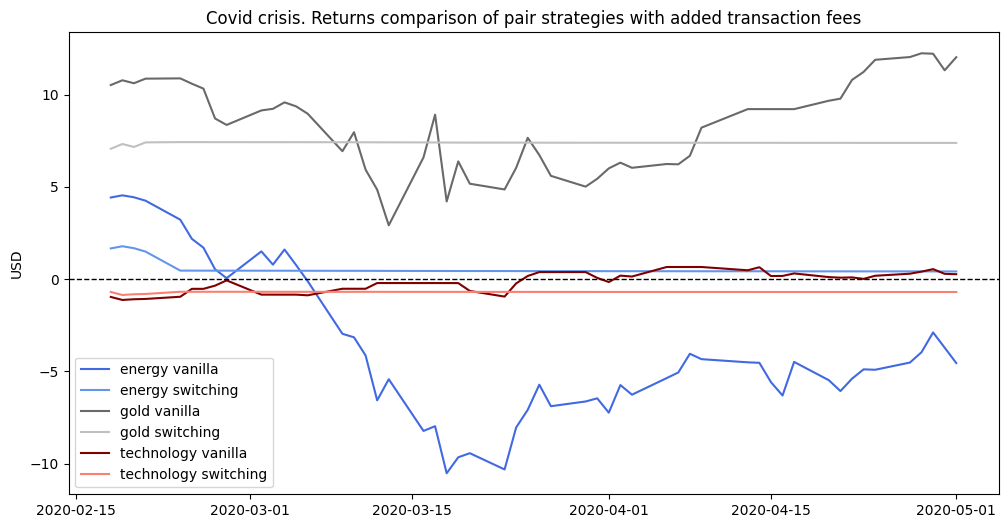

In [98]:
start_covid = '2020-02-15'
end_covid = '2020-05-01'

plt.plot(cum_pnl_energy_no_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_energy_no_switch_shaved.loc[start_covid:end_covid], color='royalblue', label="energy vanilla")
plt.plot(cum_pnl_energy_with_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_energy_with_switch_shaved.loc[start_covid:end_covid], color='cornflowerblue', label="energy switching")
plt.plot(cum_pnl_gold_no_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_gold_no_switch_shaved.loc[start_covid:end_covid], color='dimgrey', label="gold vanilla")
plt.plot(cum_pnl_gold_with_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_gold_with_switch_shaved.loc[start_covid:end_covid], color='silver', label="gold switching")
plt.plot(cum_pnl_tech_no_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_tech_no_switch_shaved.loc[start_covid:end_covid], color='maroon', label="technology vanilla")
plt.plot(cum_pnl_tech_with_switch_shaved.loc[start_covid:end_covid].index, cum_pnl_tech_with_switch_shaved.loc[start_covid:end_covid], color='salmon', label="technology switching")
plt.axhline(0, ls="--", color="k", lw=1)
plt.ylabel("USD")
plt.title("Covid crisis. Returns comparison of pair strategies with added transaction fees")
plt.legend(loc="lower left")
plt.show()

In the graph above, the pair strategies with added volatility-based regime-switching indicator are plotted in light colors.
It can be seen that the regime-switching indicator turns off the trading for all three sectors, with the indicator for the Gold ETFs strategy anticipating by a few days the other two.
This means the crisis regime has been timely captured by the indicator, which renders the strategies inactive for the whole crisis period.

Vanilla strategies for the Energy and Gold, on the other hand, experience wild swings in returns, with large drawdowns that send the Energy vanilla strategy deeply in the red.
The Technology vanilla strategy instead keeps on trading blithely, and it even realises a modest gain at the end of the period, notwithstanding the ongoing Covid crisis.
The Gold vanilla strategy also outperforms its regime-switching enhanced version, although the big drawdown it experiences certainly does not constitute a desirable side effect.

This again leaves the Energy sector as the one which benefits the most from the regime-switching indicator halting all trades during high-volatility crises.

In [99]:
def extractPercentage(vanilla, switch):
    return (switch - vanilla) / vanilla * 100

#### List evidence-based improvements to the regime-aware approach

As already mentioned previously within this section, the Energy sector pair strategy is the one which benefits the most from an added volatility based regime-switching indicator, so here we will summarise some of these improvements.

In [100]:
print(f"The improvement in cumulative PnL resulting from adopting the regime-aware approach amounts to {extractPercentage(5.2057,7.3274):.2f} % for the Energy pair.")

The improvement in cumulative PnL resulting from adopting the regime-aware approach amounts to 40.76 % for the Energy pair.


- Halting all trades during crisis periods allows the regime-aware approach to avoid losses due to the breakdown of the co-integration relation at the foundation of the pair strategy algorithm. This is reflected in cumulative returns improving by $40.76 \%$, going from $5.21$ for the vanilla strategy, to $7.33$ with the regime-switching enhancement.

In [101]:
print(f"The improvement in annualised Sharpe ratio resulting from adopting the regime-aware approach amounts to {extractPercentage(0.1805, 0.3713):.2f} % for the Energy pair.")

The improvement in annualised Sharpe ratio resulting from adopting the regime-aware approach amounts to 105.71 % for the Energy pair.


- The Sharpe ratio offers a measure of returns per unit of risk (the latter expressed as volatility).
Clearly the Energy sector is affected by volatility in the markets, so a regime-switching artifact based on volatility decisively helps in increasing the Sharpe ratio of the pair strategy by more than double ($105.71 \%$), from $0.18$ for the vanilla strategy, up to $0.37$.
Avoiding to enter trades during high-volatility periods for this sector minimises risk assumption.

In [102]:
print(f"The improvement in maximum drawdown resulting from adopting the regime-aware approach amounts to {extractPercentage(-264.1619, -140.3723):.2f} % for the Energy pair")

The improvement in maximum drawdown resulting from adopting the regime-aware approach amounts to -46.86 % for the Energy pair


- Maximum drawdown is mostly important from a psychological point of view, as traders and investors are naturally averse to big losses that keep going down.
Drawdowns are also deleterious in that they increase margins, and lead to stiffer capital requirements.
The pair strategy in the Energy sector sees a reduction in maximum drawdown of $-46.86 \%$, moving from a big trough of $-264 \%$ in the vanilla implementation, to a much reduced $-140 \%$ when the regime-switching indicator is enabled.

In [103]:
print(f"The improvement in number of trades resulting from adopting the regime-aware approach amounts to {extractPercentage(1054, 837):.2f} % for the Energy pair")
print(f"The improvement in winning rate resulting from adopting the regime-aware approach amounts to {extractPercentage(50.0949, 50.5376):.2f} % for the Energy pair")

The improvement in number of trades resulting from adopting the regime-aware approach amounts to -20.59 % for the Energy pair
The improvement in winning rate resulting from adopting the regime-aware approach amounts to 0.88 % for the Energy pair


- Secondary features like number of trades and ratio of those trades turning out to be profitable (winning ratio) are also improved when adopting the regime-aware approach within the Energy sector pair trading strategy.
The number of trades is reduced going from the vanilla strategy ($1054$ trades during 2017-22) to the enhanced one ($837$ trades) by $-20.59 \%$, stemming from the suspension of trading activities induced by the indicator during crisis periods.
A part from avoidance of entering likely-losing trades, less trading activity also leads to save on transaction fees.
In the same context, the winning ratio slightly increasing from $50.09 \%$ vanilla to $50.54 \%$ regime-aware - an overall $0.88 \%$ jump - translates to roughly 10 negative trades avoided in a 5 years period.
Most likely, these losing trades were avoided by halting trading during the Covid crisis period.

## Step 5

### Executive Summary

This project aimed to show that a straightforward pairs trading strategy can be significantly enhanced by strategically pausing it during periods of market stress. Our approach, which relies on our indicator of upcoming high volatility as a proxy for market stress, proved highly effective in the case of  energy and gold ETF pairs, but was less effective for technology pairs. Which we had expected from the historical relationship of the pairs. The goal was to build a robust, implementable strategy that could navigate real-world market conditions for pair trading, which exploits the relationship between two assets on the same sector to exploit imbalances in the way they are valuated and gain from the return to their normal relationship without the complexity of an advanced trading model.

Our analysis showed that the relationships between energy and gold ETFs were stable, allowing our simple model to generate positive cumulative returns and strong risk-adjusted returns. For these two asset classes, the strategy effectively identified and capitalized on temporary divergences, leading to profitable trades. In stark contrast, the relationships within the technology sector proved to be inherently complex and non-linear. This unpredictability meant our simple model could not accurately forecast their behavior, leading to poor performance with respect to the other two pairs. This highlights a critical lesson: a pair trading strategy's success is fundamentally tied to the inherent behavior and characteristics of the relationship of the pairs being traded. We believe the fact that technology stocks are more subject to speculative views due to rapid changes in the ecosystem might be the reason for the pair having a more complicated relationship.

We evaluated two strategies, one based on the pairs only and another one which used an indicator for upcoming high volatility, which allows us to stop trading before market stress comes and we face big losses. By being strategically patient and turning off the strategy during high-volatility periods, we successfully controlled for risk and avoided major losses in the energy and gold portfolios. This pause mechanism was the only method for managing risk that we implemented. While it prevented us from entering new positions during dangerous market conditions, it did not provide an active means of managing risk on open trades. This is why the strategy experienced significant drawdowns, which would need to be addressed with a more comprehensive risk management framework. Our project clearly shows that a more robust approach to drawdown control is essential. For instance, establishing rules to exit losing positions before they escalate would be the logical next step for improving this strategy, however these were out of the scope of the project. 

All of our simulations, including the summarized results, fully accounted for transaction costs, making these findings a realistic benchmark for a portfolio manager. Also notice that $50\%$ of the trades are winning trades, while this sounds low, our winnings are a lot bigger than our losses, which allows for significant returns. Ultimately, our work proves that a simple, disciplined strategy of avoiding market turmoil can dramatically improve performance for certain asset classes. However, it must be paired with clear rules for drawdown control, in order to be a complete and effective solution ready for real-world application.

## Step 6

### Job Interview Preparation

#### 1. I see you used a BDS test. Walk me through what that told you about your trading strategy's residuals and why that insight is valuable beyond just looking at the P&L.

When one designs a trading strategy, one should try to exploit all patters available, the residuals (the difference between our predictions and the actual returns) should be random, what the BDS tells me that the P&L can't is whether I'm missing patterns that I could use to increase my returns, specifically it tells me of I'm missing nonlinear patterns. The fact that the $p$-value of the BDS test is high tells me that my residuals are random (independently and identically distributed), it tells me that my model is somehow complete since the difference between my predictions and reality do not exhibit any pattern.

The reason that this is valuable is that I can generalize my model to include patterns, or try different transformations to see what kind of pattern one might be missing, we performed a $GARCH(1,1)$ model on the residuals to realize that most of the nonlinear relationship between the pair that we do not capture is volatility clustering.

#### 2. We often see correlated pairs blow up. How did you statistically verify that your chosen pair was more than just correlated and was actually suitable for a mean-reversion strategy? What's the biggest pitfall in this process?

Indeed, correlation spikes during crisis, however one needs to keep in mind that correlation only talks about the short-term linear relationship between the pairs, while co-integration is about a long-term, equilibrium/mean-reversal relationship between the two assets in the pair. 

Since the cointegration is done, in a long timescale compared to that of correlation spikes (years instead of weeks) that in itself tells us we're not merely looking at correlation. On the technical side, the Engle-Granger test was performed, this test checks that the the each of the assets individually, undergoes unpredictable movements (it's non-stationary), for a pair to be cointegrated both time series need to be non-stationary, this was check with the Augmented Dickey-Fuller test (ADF), we then use linear regression to find a linear combination of their prices that is stationary (that is it moves around some value, we call  this behaviour mean reverting), again this was checked with ADF.

The biggest pitfall is what is known as "spurious regression", this happens when we confuse a long-term correlation with cointegration, while in theory the ADF test saves us from this however, the linear regression might be a bit off, or changes in the pair assets, macro or other disruptive events, might break down the relation between the series, so one should always keep checking for cointegration to avoid trading what might be a broken strategy.

#### 3. Your model identified a high-volatility regime. What was the practical trigger for switching the strategy off? How would you convince a skeptical portfolio manager that this isn't just data-snooping and will work going forward?

The practical trigger for switching the strategy on and off, is a high probability of being in the high volatility regime  (which we call a stressed regime). This probability was set at 0.9, which we believe it is reasonable, while one might think that lower probabilities would be better, to quote Peter Lynch  "Far more money has been lost by investors preparing for corrections or trying to anticipate corrections than has been lost in corrections themselves" so we think it's worth minimizing false negatives.

In order to convince a skeptical portfolio manager, I would point that:

- The regimes are not just statistical constructs, but that they clearly represent calm and distressed markets, that they should think of it as a systematic threshold for the well known VIX that will signal turmoil.
- Our backtesting shows that the strategy outperforms the alternative, this proves that it adds value beyond mere data-snooping
- It adds proactive risk management that is based on a signal to avoid losses rather than reacting to the losses to minimize them, it is a forward looking risk management tool

#### 4a. This project involves combining multiple models. Tell me about a time during this project where one of your models failed or produced a counterintuitive result. How did you troubleshoot and solve the problem?

In any of the models we are using the residuals of the pairs, a problem I stumbled across was the fact than when I first tested the data, the BDS test indicated that there was a nonlinear dependence in virtually all regimes and all datasets which was counterintuitive, indicating that models based on a linear pair strategy like the one we had plan would be missing the patterns in the data.  

To troubleshoot this we took a look at the z-values over the different scales since they were all large  (around two orders of magnitude bigger than expected)
and positive, whenever this happens and we study a large timeframe we should suspect the main pattern that we are not explaining is volatility clustering, we used a $GARCH(1,1)$ model on the residuals and performed the BDS test there to verify this assumption, once we did we saw how the residuals were random  around most scales with a $95\%$ confidence confirming that the pattern we miss is volatility clustering.

#### 4b. This project involves combining multiple models. Tell me about a time during this project where one of your models failed or produced a counterintuitive result. How did you troubleshoot and solve the problem?

When I was looking for cointegration strategies, I was struggling with the fact that the data we used was not cointegrated (XLE vs. XOP). The residuals were failing the  ADF test as the p values were too high. The problem itself had to do with the way the ADF test is done in the statmodels library, basically there are several types of regression on which one can look for the residuals, the default value was not appropriate in this case, by reading the documentation and changing the default value I was not only able to solve the problem but better understand the data and the reasons the cointegration strategy doesn't do so good here, the reason is that the data is only cointegrated if the data had no drift, but it does have a small downward drift up to march 2020. Understanding this fail allowed me to understand how strong the cointegration is in this case (based on how general the regression is in each case).

#### 4c. This project involves combining multiple models. Tell me about a time during this project where one of your models failed or produced a counterintuitive result. How did you troubleshoot and solve the problem?

A problem I ran into was that the parameters for the regime switching strategy (Markov Switching Autoregression) were orders of magnitude apart,a clear sign of an unstable and potentially overfit model, making it unreliable for a live trading strategy., To solve this I imposed reasonable  but not overly restrictive, bounds on the parameters.

By constraining the optimization to a meaningful search space, the model's parameters became far more reasonable and the resulting regime classifications were consistent, interpretable, and economically sound. This process was not an act of data-snooping, but a necessary regularization step to ensure the model was well-posed and the resulting parameters were statistically meaningful.

## References

- Yahoo Finance, [**https://finance.yahoo.com/**](https://finance.yahoo.com), accessed on 18th September 2025
- WorldQuant University, **Capstone Review course: Module 5**, accessed on 18th September 2025
- WorldQuant University, **Financial Econometrics course**, accessed on 18th September 2025
- Statsmodels Python package, [**documentation**](https://www.statsmodels.org/dev/index.html), version 0.15.0 (+753)